## Raking of Synthetic AllOfUs Data on N Variables

This notebook performs raking on N simultaneous variables (N >= 2). Weights are computed for an unweighted source sample so that specified marginal distributions match those of a weighted target population.

The source and target datasets **must** obey an identical coding scheme.

The target population is that specified by the PUMS data release. The PUMS data files and the associated codebook can be found here: https://www.census.gov/programs-surveys/acs/data/experimental-data/2020-1-year-pums.html . The recoded PUMS file is generated by the `PUMS-Recoding.ipynb` notebook.

In [1]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from collections import Counter, defaultdict

from src import plots, pdf, autocollapse, raking, census_divisions as census

# coding file - ensure that the input files were generated with the selected coding scheme
from src import coding_aou as CODING

### User Parameters

In [2]:
# Identifiers for the variables to be raked (from the coding file) - also specifies their ordering.
# *** The ordering of the variables affects the raking metric. ***

RAKE_DATA = [
    # variable enum,              # recoded source var name,   # recoded PUMS var name
    (CODING.Variables.AGE,        'AGE_GROUPING',              'Age'),          
    (CODING.Variables.RACE_ETH,   'RACE_GROUPING',             'RaceEth'),
    (CODING.Variables.INSURANCE,  'INSURANCE_GROUPING',        'Insurance'),
    (CODING.Variables.EDUCATION,  'EDUCATION_GROUPING',        'Education'),
    (CODING.Variables.INCOME,     'INCOME_GROUPING',           'Income'),  
    (CODING.Variables.SEX,        'SEX_AT_BIRTH',              'Sex'),        
]

# map of the enumvar to (source, target) colum name tuple
RAKE_MAP = {enumvar:(source_col, target_col) for enumvar, source_col, target_col in RAKE_DATA}

# threshold for auto-collapse of bins - might need a different threshold for each variable
AUTO_COLLAPSE_THRESHOLD = 100

# minimum count in any cell of any source marginal distribution prior to raking
MIN_CELL_SIZE = 50

# directory where the source and target recoded input files are located
DATA_DIR = 'data'

# recoded PUMS file for all 50 states and DC
PUMS_RECODED_FILE_NAME = 'pums_usa_2019_recoded_aou.csv'

# name of the recoded NHIS data
AOU_RECODED_FILE_NAME = 'synthetic_aou.csv'

# a weighted version of the source file will be written to DATA_DIR
OUTPUT_FILE_NAME = 'aou_weighted.csv'

# Whether to use weighted PUMS counts, which are required for true population counts (PUMS 'PWGTP' variable).
# Set to None to use an unweighted target population.
PUMS_WEIGHT_COL = 'PWGTP'

# use source and target data from this state
STATE = 'GA'

### End of User Input

#### Map of state abbreviations to PUMS state codes

In [3]:
STATE_CODE_MAP = {
    'AZ' : 4,
    'CA' : 6,
    'CT' : 9,
    'GA' : 13,
    'MS' : 28,
    'NV' : 32,    
    'SC' : 45,
    'TN' : 47,
    
    # others TBD
}

#### Setup some parameters

In [4]:
# list of enumerated variables to be raked
RAKEVARS = [tup[0] for tup in RAKE_DATA]

# map of variable enum to source file col name
AOU_COL_MAP = {RAKEVARS[i]:RAKE_DATA[i][1] for i in range(len(RAKEVARS))}

# map of variable enum to PUMS file col name
PUMS_COL_MAP = {RAKEVARS[i]:RAKE_DATA[i][2] for i in range(len(RAKEVARS))}

# get the names of the variables, in order
RAKEVAR_NAMES = [CODING.VAR_NAMES[enumvar] for enumvar in RAKEVARS]
RAKEVAR_NAMES

['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']

#### Determine the number of bins required to hold each variable

Categorical values for a given variable are **assumed** to be a contiguous block of integers starting at 0.

In [5]:
# bin counts in order of the variables
BIN_COUNTS = []

for enumvar in RAKEVARS:
    BIN_COUNTS.append(CODING.BIN_COUNTS[enumvar])

# maximum-length variable name, used for prettyprinting
maxlen = max([len(var_name) for var_name in RAKEVAR_NAMES])

print('Bin counts: ')
for i in range(len(RAKEVAR_NAMES)):
    print('{0:>{2}} : {1}'.format(RAKEVAR_NAMES[i], BIN_COUNTS[i], maxlen))

Bin counts: 
      Age : 6
  RaceEth : 5
Insurance : 2
Education : 4
   Income : 5
      Sex : 2


#### Input Files

Construct paths to the input files relative to this notebook.

In [6]:
# recoded PUMS file for the entire USA
TARGET_FILE = os.path.join(DATA_DIR, PUMS_RECODED_FILE_NAME)

# source file
SOURCE_FILE = os.path.join(DATA_DIR, AOU_RECODED_FILE_NAME)

print('Target file: {0}'.format(TARGET_FILE))
print('Source file: {0}'.format(SOURCE_FILE))

Target file: data/pums_usa_2019_recoded_aou.csv
Source file: data/synthetic_aou.csv


#### Load the Target File

In [7]:
print('Loading target file "{0}"...'.format(TARGET_FILE))
pums_usa_df = pd.read_csv(TARGET_FILE)
pums_usa_df

Loading target file "data/pums_usa_2019_recoded_aou.csv"...


,Age,Education,Income,Insurance,PWGTP,RaceEth,SERIALNO,SPORDER,ST,Sex
0,2,1,2,0,23,3,2019HU0915504,1,1,0
1,4,2,1,0,71,0,2019HU0915555,1,1,1
2,5,0,0,0,53,0,2019HU0915555,2,1,0
3,5,2,1,0,25,1,2019HU0915664,1,1,1
4,0,0,2,0,38,0,2019HU0915711,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2599166,3,1,2,0,125,0,2019HU1000576,1,56,0
2599167,3,1,0,0,134,0,2019HU1000576,2,56,1
2599168,4,2,0,0,24,0,2019HU1000791,1,56,1
2599169,1,0,1,0,48,3,2019HU0999472,1,56,1


#### Print some PUMS information

In [55]:
def weighted_value_counts(df, weights, bin_counts, var_names):
    """
    Assumes bin_counts[i] contains the number of bins for the variable at var_names[i].
    """
    
    # these arrays will accumulate the categorical counts for each variable
    count_arrays = []
    for i, var in enumerate(var_names):
        counts = np.zeros(bin_counts[i])
        count_arrays.append(counts)
    
    for i, var in enumerate(var_names):
        counts = count_arrays[i]
        samples = df[var].values
        for j in range(len(samples)):
            counts[samples[j]] += weights[j]
            
    return count_arrays

In [58]:
sum_of_weights = np.sum(pums_usa_df['PWGTP'].values)
print('Sum of weights: {0}'.format(sum_of_weights))
counts_list = weighted_value_counts(pums_usa_df, pums_usa_df['PWGTP'].values, BIN_COUNTS, RAKEVAR_NAMES)
for i, counts in enumerate(counts_list):
    print('{0}: '.format(RAKEVAR_NAMES[i]))
    checksum = 0
    for k in range(len(counts)):
        count = counts[k]
        print('\t{0} : {1:>15}'.format(k, count))
        checksum += count
    assert sum_of_weights == checksum
    print()

Sum of weights: 255327593
Age: 
	0 :      58335023.0
	1 :      47127202.0
	2 :      40596748.0
	3 :      39240174.0
	4 :      36432234.0
	5 :      33596212.0

RaceEth: 
	0 :     160425714.0
	1 :      29851764.0
	2 :      12759290.0
	3 :      41638505.0
	4 :      10652320.0

Insurance: 
	0 :     228283387.0
	1 :      27044206.0

Education: 
	0 :      99325657.0
	1 :      56409821.0
	2 :      71766896.0
	3 :      27825219.0

Income: 
	0 :     118895537.0
	1 :      58479144.0
	2 :      53400605.0
	3 :      24552307.0
	4 :             0.0

Sex: 
	0 :     124252949.0
	1 :     131074644.0



#### Extract data for the specified state

In [10]:
assert STATE in STATE_CODE_MAP
state_code = STATE_CODE_MAP[STATE]
    
# extract all rows for these states
pums_df = pums_usa_df.loc[pums_usa_df['ST'] == state_code]

# keep specified data cols and weight col, drop all others
keep_cols = [col for col in PUMS_COL_MAP.values()]
keep_cols.append(PUMS_WEIGHT_COL)
pums_df = pums_df[keep_cols]
pums_df = pums_df.reset_index(drop=True)
pums_df

,Age,RaceEth,Insurance,Education,Income,Sex,PWGTP
0,4,0,0,0,2,1,69
1,3,0,0,3,1,0,96
2,3,0,1,1,0,0,91
3,2,0,0,2,2,0,143
4,3,0,0,3,0,1,139
...,...,...,...,...,...,...,...
80649,0,1,0,1,0,1,154
80650,2,4,0,0,1,1,37
80651,5,1,0,0,2,0,142
80652,1,1,1,1,0,1,68


#### Load the Source File

In [11]:
raw_source_df = pd.read_csv(SOURCE_FILE)

# extract required cols
cols = [c for c in AOU_COL_MAP.values()]
cols.append('STATE')
source_df = raw_source_df[cols]

# extract data for desired state
source_df = source_df[source_df['STATE'] == STATE]
source_df = source_df.reset_index(drop=True)
    
source_df

,AGE_GROUPING,RACE_GROUPING,INSURANCE_GROUPING,EDUCATION_GROUPING,INCOME_GROUPING,SEX_AT_BIRTH,STATE
0,1,0,0,1,0,1,GA
1,4,1,0,2,0,1,GA
2,4,0,0,2,3,1,GA
3,2,4,0,0,4,1,GA
4,1,1,0,0,0,1,GA
...,...,...,...,...,...,...,...
6135,3,0,0,0,3,0,GA
6136,5,1,1,0,4,2,GA
6137,2,0,0,0,2,1,GA
6138,5,1,0,0,0,1,GA


### Recoding

Recode each categorical value in `coding_aou_raw.py` to match the coding scheme in `coding_aou.py`.

In [12]:
age_recode  = {
    0:0, # 20-29 => 18_29
    1:1, # 30-39 => 30_39
    2:2, 
    3:3, 
    4:4, 
    5:5, # 70-79 => 70_plus
    6:5, # 80-89 => 70_plus
    7:5, # 90-99 => 70_plus
}

race_recode = {
    0:0, # NH White => NH White
    1:1, # NH Black => NH Black
    2:2, # NH Asian => NH Asian
    3:3, # Hispanic => Hispanic
    4:4, # Other => Other
}

insurance_recode = {
    0:0, # Yes => Yes
    1:1, # No => No
    2:1, # Missing => No
}

education_recode = {
    0:0, # College Grad => College Grad
    1:1, # Some College => Some College
    2:2, # HS Grad => HS Grad
    3:3, # Not HS Grad => Not HS Grad
    4:0, # Missing => College Grad
}

income_recode = {
    0:0, # less than $25K => less than $25K
    1:1, # [$25K, $50K) => [$25K, $50K)
    2:2, # [$50K, $100K) => [$50K, $100K)
    3:3, # $100K or more => $100K or more
    4:4, # Missing => Missing
}

sex_recode = {
    0:0, # Male => Male
    1:1, # Female => Female
    2:0, # Other => Male
}

In [13]:
# recoded_age = source_df['AGE_GROUPING'].map(age_recode)
# recoded_race = source_df['RACE_GROUPING'].map(race_recode)
# recoded_insurance = source_df['INSURANCE_GROUPING'].map(insurance_recode)
# recoded_education = source_df['EDUCATION_GROUPING'].map(education_recode)
# recoded_income = source_df['INCOME_GROUPING'].map(income_recode)
# recoded_sex = source_df['SEX_AT_BIRTH'].map(sex_recode)

# source_df = source_df.assign(AGE_GROUPING = recoded_age)
# source_df = source_df.assign(RACE_GROUPING = recoded_race)
# source_df = source_df.assign(INSURANCE_GROUPING = recoded_insurance)
# source_df = source_df.assign(EDUCATION_GROUPING = recoded_education)
# source_df = source_df.assign(INCOME_GROUPING = recoded_income)
# source_df = source_df.assign(SEX_AT_BIRTH = recoded_sex)

# map each variable to its value map
RECODE_MAP = {
    CODING.Variables.AGE       : age_recode,
    CODING.Variables.RACE_ETH  : race_recode,
    CODING.Variables.SEX       : sex_recode,
    CODING.Variables.EDUCATION : education_recode,
    CODING.Variables.INCOME    : income_recode,
    CODING.Variables.INSURANCE : insurance_recode
}

# do the recodings
for enumvar, tup in RAKE_MAP.items():
    source_col, target_col = tup
    value_map = RECODE_MAP[enumvar]
    recoded_values = source_df[source_col].map(value_map)
    source_df = source_df.assign(**{source_col:recoded_values})

In [14]:
source_df

,AGE_GROUPING,RACE_GROUPING,INSURANCE_GROUPING,EDUCATION_GROUPING,INCOME_GROUPING,SEX_AT_BIRTH,STATE
0,1,0,0,1,0,1,GA
1,4,1,0,2,0,1,GA
2,4,0,0,2,3,1,GA
3,2,4,0,0,4,1,GA
4,1,1,0,0,0,1,GA
...,...,...,...,...,...,...,...
6135,3,0,0,0,3,0,GA
6136,5,1,1,0,4,0,GA
6137,2,0,0,0,2,1,GA
6138,5,1,0,0,0,1,GA


### State-specific collapsing

#### Collapse Age

In [15]:
# source_df = CODING.collapse_age(source_df, 'STATE', 'AGE_GROUPING')

# # check

# # Connecticut, state code 9
# check_values = source_df[source_df['STATE']=='CT']['AGE_GROUPING'].values
# ctr = Counter(check_values)
# assert 0 not in ctr.keys()
# # South Carolina, state code 45
# check_values = source_df[source_df['STATE']=='SC']['AGE_GROUPING'].values
# ctr = Counter(check_values)
# assert 5 not in ctr.keys()
# # States in the West North Central census division
# check_values = source_df[source_df['STATE'].isin({'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'})]['AGE_GROUPING'].values
# ctr = Counter(check_values)
# assert 3 not in ctr.keys()
# assert 4 not in ctr.keys()
# assert 5 not in ctr.keys()

# COLLAPSE AGE

if CODING.Variables.AGE in RAKE_MAP:
    source_age_col, target_age_col = RAKE_MAP[CODING.Variables.AGE]
    source_df = CODING.collapse_age(source_df, 'STATE', source_age_col)

    # check

    # Connecticut, state code 9
    check_values = source_df[source_df['STATE']=='CT'][source_age_col].values
    ctr = Counter(check_values)
    assert 0 not in ctr.keys()
    # South Carolina, state code 45
    check_values = source_df[source_df['STATE']=='SC'][source_age_col].values
    ctr = Counter(check_values)
    assert 5 not in ctr.keys()
    # States in the West North Central census division
    check_values = source_df[source_df['STATE'].isin({'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'})][source_age_col].values
    ctr = Counter(check_values)
    assert 3 not in ctr.keys()
    assert 4 not in ctr.keys()
    assert 5 not in ctr.keys()   

#### Collapse RaceEth

In [16]:
# source_df = CODING.collapse_raceeth(source_df, 'STATE', 'RACE_GROUPING')

# # check

# # CT, TN, DIV_ESC, DIV_WSC
# check_values = source_df[source_df['STATE'].isin({'CT', 'TN', 'AL', 'KY', 'MS', \
#                                                   'TN', 'AR', 'LA', 'OK', 'TX'})]['RACE_GROUPING'].values
# ctr = Counter(check_values)
# assert 2 not in ctr.keys()
# # South Carolina, state code 45
# check_values = source_df[source_df['STATE']=='SC']['RACE_GROUPING'].values
# ctr = Counter(check_values)
# assert 2 not in ctr.keys()
# assert 4 not in ctr.keys()
# # LA and MS, codes 22 and 28
# check_values = source_df[source_df['STATE'].isin({'LA', 'MS'})]['RACE_GROUPING'].values
# ctr = Counter(check_values)
# assert 2 not in ctr.keys()
# assert 3 not in ctr.keys()

# COLLAPSE RACE

if CODING.Variables.RACE_ETH in RAKE_MAP:
    source_race_col, target_race_col = RAKE_MAP[CODING.Variables.RACE_ETH]
    source_df = CODING.collapse_raceeth(source_df, 'STATE', source_race_col)

    # check

    # CT, TN, DIV_ESC, DIV_WSC
    check_values = source_df[source_df['STATE'].isin({'CT', 'TN', 'AL', 'KY', 'MS', \
                                                      'TN', 'AR', 'LA', 'OK', 'TX'})][source_race_col].values
    ctr = Counter(check_values)
    assert 2 not in ctr.keys()
    # South Carolina, state code 45
    check_values = source_df[source_df['STATE']=='SC'][source_race_col].values
    ctr = Counter(check_values)
    assert 2 not in ctr.keys()
    assert 4 not in ctr.keys()
    # LA and MS, codes 22 and 28
    check_values = source_df[source_df['STATE'].isin({'LA', 'MS'})][source_race_col].values
    ctr = Counter(check_values)
    assert 2 not in ctr.keys()
    assert 3 not in ctr.keys() 

#### Collapse Education

In [17]:
# source_df = CODING.collapse_education(source_df, 'STATE', 'EDUCATION_GROUPING')

# # check

# # DIV_WNC
# check_values = source_df[source_df['STATE'].isin({'IA', 'KS', 'MN', 'MO', \
#                                                   'NE', 'ND', 'SD'})]['EDUCATION_GROUPING'].values
# ctr = Counter(check_values)
# assert 3 not in ctr.keys()

# COLLAPSE EDUCATION

if CODING.Variables.EDUCATION in RAKE_MAP:
    source_edu_col, target_edu_col = RAKE_MAP[CODING.Variables.EDUCATION]
    source_df = CODING.collapse_education(source_df, 'STATE', source_edu_col)

    # check

    # DIV_WNC
    check_values = source_df[source_df['STATE'].isin({'IA', 'KS', 'MN', 'MO', \
                                                      'NE', 'ND', 'SD'})][source_edu_col].values
    ctr = Counter(check_values)
    assert 3 not in ctr.keys()

#### Collapse Income

In [18]:
# source_df = CODING.collapse_income(source_df, 'STATE', 'INCOME_GROUPING')

# # CT, MS, TN, and SC
# check_values = source_df[source_df['STATE'].isin({'CT', 'MS', 'TN', 'SC'})]['INCOME_GROUPING'].values
# ctr = Counter(check_values)
# assert 3 not in ctr.keys()
# # DIV_WNC
# check_values = source_df[source_df['STATE'].isin({'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'})]['INCOME_GROUPING'].values
# ctr = Counter(check_values)
# assert 1 not in ctr.keys()

# COLLAPSE INCOME

if CODING.Variables.INCOME in RAKE_MAP:
    source_income_col, target_income_col = RAKE_MAP[CODING.Variables.INCOME]

    source_df = CODING.collapse_income(source_df, 'STATE', source_income_col)

    # CT, MS, TN, and SC
    check_values = source_df[source_df['STATE'].isin({'CT', 'MS', 'TN', 'SC'})][source_income_col].values
    ctr = Counter(check_values)
    assert 3 not in ctr.keys()
    # DIV_WNC
    check_values = source_df[source_df['STATE'].isin({'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'})][source_income_col].values
    ctr = Counter(check_values)
    assert 1 not in ctr.keys()

### Automatic Collapsing

In [19]:
ORDERED_VARIABLES = {CODING.Variables.AGE, CODING.Variables.EDUCATION, CODING.Variables.INCOME}

# South Carolina changes the "other" bin for RaceEth
AUTO_COLLAPSE_RACE_OTHER = CODING.RaceEth.OTHER.value
if 'SC' == STATE:
    AUTO_COLLAPSE_RACE_OTHER = 0

for enumvar, source_col, target_col in RAKE_DATA:
    
    print('Variable: {0}'.format(enumvar))
    print('BEFORE: ')
    ctr = Counter(source_df[source_col].values)
    for k in sorted(ctr.keys()):
        print('{0} => {1}'.format(k, ctr[k]))
    ctr = Counter(pums_df[target_col].values)
    for k in sorted(ctr.keys()):
        print('\t{0} => {1}'.format(k, ctr[k]))
    print()    
    
    if enumvar in ORDERED_VARIABLES:
                
        source_df, change_list = autocollapse.full_collapse_ordered(source_df,
                                                                    source_col,
                                                                    AUTO_COLLAPSE_THRESHOLD)        
        pums_df = autocollapse.collapse_from_changelist(pums_df, target_col, change_list)
        
        print('\tchange_list: {1}'.format(enumvar, change_list)) 
        
    elif enumvar == CODING.Variables.RACE_ETH:
        # unordered
        source_df, change_list = autocollapse.full_collapse_unordered(source_df,
                                                                      source_col,
                                                                      threshold = AUTO_COLLAPSE_THRESHOLD,
                                                                      other_col = AUTO_COLLAPSE_RACE_OTHER)
        pums_df = autocollapse.collapse_from_changelist(pums_df, target_col, change_list)
        
        print('\tchange_list: {1}'.format(enumvar, change_list)) 
        
    else:
        # TBD for insurance, sex
        pass
        
    print('AFTER: ')
    ctr = Counter(source_df[source_col].values)
    for k in sorted(ctr.keys()):
        print('{0} => {1}'.format(k, ctr[k]))
    ctr = Counter(pums_df[target_col].values)
    for k in sorted(ctr.keys()):
        print('\t{0} => {1}'.format(k, ctr[k]))
    print()

Variable: Variables.AGE
BEFORE: 
0 => 386
1 => 675
2 => 800
3 => 1317
4 => 1619
5 => 1343
	0 => 14796
	1 => 12164
	2 => 12542
	3 => 14294
	4 => 13680
	5 => 13178

	change_list: []
AFTER: 
0 => 386
1 => 675
2 => 800
3 => 1317
4 => 1619
5 => 1343
	0 => 14796
	1 => 12164
	2 => 12542
	3 => 14294
	4 => 13680
	5 => 13178

Variable: Variables.RACE_ETH
BEFORE: 
0 => 2044
1 => 3423
2 => 200
3 => 156
4 => 317
	0 => 51833
	1 => 19246
	2 => 3114
	3 => 5119
	4 => 1342

	change_list: []
AFTER: 
0 => 2044
1 => 3423
2 => 200
3 => 156
4 => 317
	0 => 51833
	1 => 19246
	2 => 3114
	3 => 5119
	4 => 1342

Variable: Variables.INSURANCE
BEFORE: 
0 => 4843
1 => 1297
	0 => 69638
	1 => 11016

AFTER: 
0 => 4843
1 => 1297
	0 => 69638
	1 => 11016

Variable: Variables.EDUCATION
BEFORE: 
0 => 2937
1 => 1371
2 => 1331
3 => 501
	0 => 31073
	1 => 17559
	2 => 22410
	3 => 9612

	change_list: []
AFTER: 
0 => 2937
1 => 1371
2 => 1331
3 => 501
	0 => 31073
	1 => 17559
	2 => 22410
	3 => 9612

Variable: Variables.INCOME
BEFORE:

#### Build target sample arrays

In [20]:
# get the names of the target columns in the same order as the RAKEVARS array
ordered_target_cols = [PUMS_COL_MAP[enumvar] for enumvar in RAKEVARS]
print('Target columns, in order: {0}\n'.format(ordered_target_cols))

# samples taken in order of the variables in VARIABLES
TARGET_SAMPLES = [np.array(pums_df[col].values) for col in ordered_target_cols]

# set TARGET_WEIGHTS to None to rake to an unweighted target population
if PUMS_WEIGHT_COL is not None:
    TARGET_WEIGHTS = np.array(pums_df[PUMS_WEIGHT_COL].values)
    TARGET_POPULATION = np.sum(TARGET_WEIGHTS)
    print('Target population (weighted): {0}'.format(TARGET_POPULATION))
else:
    TARGET_WEIGHTS = None
    TARGET_POPULATION = len(TARGET_SAMPLES[0])    
    print('Target population (unweighted): {0}'.format(TARGET_POPULATION))

Target columns, in order: ['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']

Target population (weighted): 8115411



#### Build source sample arrays

In [21]:
# get the names of the source dataframe columns in the order matching the variables
ordered_source_cols = [AOU_COL_MAP[enumvar] for enumvar in RAKEVARS]
print('Source columns, in order: {0}\n'.format(ordered_source_cols))

# build a list of np.arrays containing the data for each col
SOURCE_SAMPLES = [np.array(source_df[col].values) for col in ordered_source_cols]

print('Sample population: {0}'.format(len(SOURCE_SAMPLES[0])))

Source columns, in order: ['AGE_GROUPING', 'RACE_GROUPING', 'INSURANCE_GROUPING', 'EDUCATION_GROUPING', 'INCOME_GROUPING', 'SEX_AT_BIRTH']

Sample population: 6140


#### Compute the number of bins required to hold each variable

Categorical values for a given variable are **assumed** to be a contiguous block of integers starting at 0.

In [22]:
# # bin counts in order of the variables
# BIN_COUNTS = []

# for enumvar in RAKEVARS:
#     BIN_COUNTS.append(CODING.BIN_COUNTS[enumvar])

# # maximum-length variable name, used for prettyprinting
# maxlen = max([len(var_name) for var_name in RAKEVAR_NAMES])

# print('Bin counts: ')
# for i in range(len(RAKEVAR_NAMES)):
#     print('{0:>{2}} : {1}'.format(RAKEVAR_NAMES[i], BIN_COUNTS[i], maxlen))

#### Useful plotting function

In [23]:
def plot_pdfs(source_unraked_pdfs, source_raked_pdfs, target_pdfs):
    
    # display precision
    P = 5
    
    num_pdfs = len(source_unraked_pdfs)
    assert len(source_raked_pdfs) == len(target_pdfs) == num_pdfs
    
    for q in range(0, num_pdfs):
        plots.triple_histogram_from_pdfs(RAKEVAR_NAMES[q], 
                                         source_unraked_pdfs[q], source_raked_pdfs[q], target_pdfs[q],
                                         labels=['Unraked Source', 'Raked Source', 'Target'])
        print('Unraked source PDF : {0}'.format(np.array_str(source_unraked_pdfs[q], precision=P)))
        print('  Raked source PDF : {0}'.format(np.array_str(source_raked_pdfs[q],   precision=P)))
        print('        Target PDF : {0}'.format(np.array_str(target_pdfs[q],         precision=P)))

## Search for the Best Raking Model

In [24]:
dim = len(RAKEVARS)
if 2 == dim:
    MODELS = raking.MODELS_2
elif 3 == dim:
    MODELS = raking.MODELS_3
elif 4 == dim:
    MODELS = raking.MODELS_4
elif 5 == dim:
    MODELS = raking.MODELS_5
elif 6 == dim:
    MODELS = raking.MODELS_6
else:
    # just use 1D marginals
    MODELS = [
        [[i] for i in range(dim)],
    ]

#score_map = {}
data = []
weight_map = {}
for model_index, model in enumerate(MODELS):
    
    print('\n[{0}/{1}]\tModel {2}:\n'.format(model_index+1, len(MODELS), model))
        
    # do the raking operation and generate weights
    raking_result_tuple = raking.rake(model,
                                      SOURCE_SAMPLES,
                                      TARGET_SAMPLES,
                                      TARGET_WEIGHTS,
                                      BIN_COUNTS,
                                      TARGET_POPULATION)
    
    if raking_result_tuple is None:
        print('\tMODEL DID NOT CONVERGE')
    else:
        weights_m, unraked_m, target_m, raked_m, fnorm_m, smallest_cell = raking_result_tuple
        if smallest_cell < MIN_CELL_SIZE:
            print('\tSource marginal cell size {0} less than cutoff {1}, discarding...'.format(smallest_cell,
                                                                                               MIN_CELL_SIZE))
        else: 
            #print('\tF-Norm : {0:.3f}\n'.format(fnorm_m))
            #score_map[index] = (fnorm_m, weights_m, smallest_cell)
            wmax = np.max(weights_m)
            print('\tMax weight: {0:.3f}'.format(wmax))
            data.append( (wmax, smallest_cell, model_index))
            weight_map[model_index] = weights_m


[1/61]	Model [[0], [1], [2], [3], [4], [5]]:

ipfn converged: convergence_rate below threshold
	Max weight: 26505.813

[2/61]	Model [[0], [1], [2], [3], [4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 25647.507

[3/61]	Model [[0], [1], [2], [4], [3, 5]]:

ipfn converged: convergence_rate below threshold
	Max weight: 24870.397

[4/61]	Model [[0], [1], [3], [4], [2, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 25940.209

[5/61]	Model [[0], [2], [3], [4], [1, 5]]:

ipfn converged: convergence_rate below threshold
	Max weight: 36517.984

[6/61]	Model [[1], [2], [3], [4], [0, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 28655.422

[7/61]	Model [[0], [1], [2], [5], [3, 4]]:

ipfn converged: convergence_rate below threshold
	Max weight: 32062.910

[8/61]	Model [[0], [1], [3], [5], [2, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 26717.001

[9/61]	Model [[0], [2], [3], [5], [1, 4]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 21.0 less than cutoff 50, discarding...

[10/61]	Model [[1], [2], [3], [5], [0, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 47.0 less than cutoff 50, discarding...

[11/61]	Model [[0], [1], [4], [5], [2, 3]]:

ipfn converged: convergence_rate below threshold
	Max weight: 38614.752

[12/61]	Model [[0], [2], [4], [5], [1, 3]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 15.0 less than cutoff 50, discarding...

[13/61]	Model [[1], [2], [4], [5], [0, 3]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 33.0 less than cutoff 50, discarding...

[14/61]	Model [[0], [3], [4], [5], [1, 2]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 38.0 less than cutoff 50, discarding...

[15/61]	Model [[1], [3], [4], [5], [0, 2]]:

ipfn converged: convergence_rate below threshold
	Max weight: 24570.385

[16/61]	Model [[2], [3], [4], [5], [0, 1]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[17/61]	Model [[4], [5], [0, 1], [2, 3]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[18/61]	Model [[3], [5], [0, 1], [2, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[19/61]	Model [[3], [4], [0, 1], [2, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[20/61]	Model [[2], [5], [0, 1], [3, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[21/61]	Model [[2], [4], [0, 1], [3, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[22/61]	Model [[2], [3], [0, 1], [4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[23/61]	Model [[4], [5], [0, 2], [1, 3]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 15.0 less than cutoff 50, discarding...

[24/61]	Model [[3], [5], [0, 2], [1, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 21.0 less than cutoff 50, discarding...

[25/61]	Model [[3], [4], [0, 2], [1, 5]]:

ipfn converged: convergence_rate below threshold
	Max weight: 34999.654

[26/61]	Model [[1], [5], [0, 2], [3, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 29866.092

[27/61]	Model [[1], [4], [0, 2], [3, 5]]:

ipfn converged: convergence_rate below threshold
	Max weight: 24087.610

[28/61]	Model [[1], [3], [0, 2], [4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 23788.793

[29/61]	Model [[4], [5], [0, 3], [1, 2]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 33.0 less than cutoff 50, discarding...

[30/61]	Model [[2], [5], [0, 3], [1, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 21.0 less than cutoff 50, discarding...

[31/61]	Model [[2], [4], [0, 3], [1, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 33.0 less than cutoff 50, discarding...

[32/61]	Model [[1], [5], [0, 3], [2, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 33.0 less than cutoff 50, discarding...

[33/61]	Model [[1], [4], [0, 3], [2, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 33.0 less than cutoff 50, discarding...

[34/61]	Model [[1], [2], [0, 3], [4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 33.0 less than cutoff 50, discarding...

[35/61]	Model [[3], [5], [0, 4], [1, 2]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 38.0 less than cutoff 50, discarding...

[36/61]	Model [[2], [5], [0, 4], [1, 3]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 15.0 less than cutoff 50, discarding...

[37/61]	Model [[2], [3], [0, 4], [1, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 47.0 less than cutoff 50, discarding...

[38/61]	Model [[1], [5], [0, 4], [2, 3]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 47.0 less than cutoff 50, discarding...

[39/61]	Model [[1], [3], [0, 4], [2, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 47.0 less than cutoff 50, discarding...

[40/61]	Model [[1], [2], [0, 4], [3, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 47.0 less than cutoff 50, discarding...

[41/61]	Model [[3], [4], [0, 5], [1, 2]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 38.0 less than cutoff 50, discarding...

[42/61]	Model [[2], [4], [0, 5], [1, 3]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 15.0 less than cutoff 50, discarding...

[43/61]	Model [[2], [3], [0, 5], [1, 4]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 21.0 less than cutoff 50, discarding...

[44/61]	Model [[1], [4], [0, 5], [2, 3]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 40110.447

[45/61]	Model [[1], [3], [0, 5], [2, 4]]:

ipfn converged: convergence_rate below threshold
	Max weight: 29071.957

[46/61]	Model [[1], [2], [0, 5], [3, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 29882.829

[47/61]	Model [[0, 1], [2, 3], [4, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[48/61]	Model [[0, 1], [2, 4], [3, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[49/61]	Model [[0, 1], [2, 5], [3, 4]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 7.0 less than cutoff 50, discarding...

[50/61]	Model [[0, 2], [1, 3], [4, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 15.0 less than cutoff 50, discarding...

[51/61]	Model [[0, 2], [1, 4], [3, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 21.0 less than cutoff 50, discarding...

[52/61]	Model [[0, 2], [1, 5], [3, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Max weight: 31103.801

[53/61]	Model [[0, 3], [1, 2], [4, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 33.0 less than cutoff 50, discarding...

[54/61]	Model [[0, 3], [1, 4], [2, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 21.0 less than cutoff 50, discarding...

[55/61]	Model [[0, 3], [1, 5], [2, 4]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 33.0 less than cutoff 50, discarding...

[56/61]	Model [[0, 4], [1, 2], [3, 5]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 38.0 less than cutoff 50, discarding...

[57/61]	Model [[0, 4], [1, 3], [2, 5]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 15.0 less than cutoff 50, discarding...

[58/61]	Model [[0, 4], [1, 5], [2, 3]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 47.0 less than cutoff 50, discarding...

[59/61]	Model [[0, 5], [1, 2], [3, 4]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 38.0 less than cutoff 50, discarding...

[60/61]	Model [[0, 5], [1, 3], [2, 4]]:



/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)
/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold
	Source marginal cell size 15.0 less than cutoff 50, discarding...

[61/61]	Model [[0, 5], [2, 4], [1, 3]]:

ipfn converged: convergence_rate below threshold
	Source marginal cell size 15.0 less than cutoff 50, discarding...


/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


#### Score and rank the results

In [25]:
def score1(weights_m, sample_count):
    """
    The original variability score.
    """
    
    # max weight
    wmax = np.max(weights_m)
    
    # 99th percentile weight
    w99 = np.percentile(weights_m, 99)
    
    # find all weights >= w99
    samples = []
    for w in weights_m:
        if w >= w99:
            samples.append(w)
    
    # std deviation of these weights
    std = np.std(samples)
    
    # the score is the product of the std deviation and the normalized max weight
    # (idea is that a model that minimizes both is better)
    score = (wmax / sample_count)  * std
    return score

In [26]:
def score2(weights_m, avg_wt):
    """
    Dr. Marker's modification of the variability score.
    """
    
    # will sum all weights >= this fraction * max_wt
    MAX_WT_FRAC = 0.9
    
    # maximum weight for this model
    wmax = np.max(weights_m)
    
    # cutoff value; compute the sum of all weights >= this cutoff
    w_cutoff = MAX_WT_FRAC * wmax
    
    samples = []
    for w in weights_m:
        if w >= w_cutoff:
            samples.append(w)
            
    w_sum = np.sum(samples)
    
    # w_sum represents this percent of the weighted total population
    pct = w_sum / TARGET_POPULATION
     
    # the score is the product of the max wt and the fraction above the cutoff, divided by the avg weight
    score = wmax * pct / avg_wt
    return score

In [27]:
sample_count = len(SOURCE_SAMPLES[0])
avg_wt = TARGET_POPULATION / sample_count

scores = []
for wmax, smallest_cell, model_index in data:
    model = MODELS[model_index]
    weights_m = weight_map[model_index]
    score = score2(weights_m, avg_wt)
    scores.append(score)

In [28]:
result_df = pd.DataFrame(data=data, columns=['Max Weight', 'Min Cell', 'Model Index'])
result_df = result_df.assign(**{'Score':scores})
model_details = result_df['Model Index'].map(lambda x: MODELS[x])
result_df = result_df.assign(**{'Model':model_details})
result_df = result_df.sort_values(by=['Max Weight'])
result_df = result_df.reset_index(drop=True)
result_df

,Max Weight,Min Cell,Model Index,Score,Model
0,23788.792746,85.0,27,0.251866,"[[1], [3], [0, 2], [4, 5]]"
1,24087.609886,85.0,26,0.160179,"[[1], [4], [0, 2], [3, 5]]"
2,24570.385394,85.0,14,0.161124,"[[1], [3], [4], [5], [0, 2]]"
3,24870.397025,156.0,2,0.057665,"[[0], [1], [2], [4], [3, 5]]"
4,25647.506670,156.0,1,0.176740,"[[0], [1], [2], [3], [4, 5]]"
5,25940.209063,156.0,3,0.121269,"[[0], [1], [3], [4], [2, 5]]"
6,26505.813194,156.0,0,0.065498,"[[0], [1], [2], [3], [4], [5]]"
7,26717.001072,156.0,7,0.066546,"[[0], [1], [3], [5], [2, 4]]"
8,28655.421957,156.0,5,0.076553,"[[1], [2], [3], [4], [0, 5]]"
9,29071.957004,156.0,44,0.078794,"[[1], [3], [0, 5], [2, 4]]"


In [29]:
display_df = result_df[['Max Weight', 'Min Cell', 'Score', 'Model']]

print('AllOfUs results for {0}, {1} samples, state population {2}:'.format(STATE,
                                                                           sample_count,
                                                                           TARGET_POPULATION))
print('\nVariables : {0}\n'.format([CODING.VAR_NAMES[enumvar] for enumvar in RAKEVARS]))
#with pd.option_context('display.precision', 2):
print(tabulate(display_df, headers = 'keys', tablefmt = 'psql', floatfmt=".2f"))
    #print(result_df)

AllOfUs results for GA, 6140 samples, state population 8115411:

Variables : ['Age', 'RaceEth', 'Insurance', 'Education', 'Income', 'Sex']

+----+--------------+------------+---------+--------------------------------+
|    |   Max Weight |   Min Cell |   Score | Model                          |
|----+--------------+------------+---------+--------------------------------|
|  0 |     23788.79 |      85.00 |    0.25 | [[1], [3], [0, 2], [4, 5]]     |
|  1 |     24087.61 |      85.00 |    0.16 | [[1], [4], [0, 2], [3, 5]]     |
|  2 |     24570.39 |      85.00 |    0.16 | [[1], [3], [4], [5], [0, 2]]   |
|  3 |     24870.40 |     156.00 |    0.06 | [[0], [1], [2], [4], [3, 5]]   |
|  4 |     25647.51 |     156.00 |    0.18 | [[0], [1], [2], [3], [4, 5]]   |
|  5 |     25940.21 |     156.00 |    0.12 | [[0], [1], [3], [4], [2, 5]]   |
|  6 |     26505.81 |     156.00 |    0.07 | [[0], [1], [2], [3], [4], [5]] |
|  7 |     26717.00 |     156.00 |    0.07 | [[0], [1], [3], [5], [2, 4]]   |
| 

In [30]:
# SORT_BY_MAX_WT = True

# if SORT_BY_MAX_WT:
#     # sort by max weight and rearrange the scores
#     wt_map = defaultdict(list)
#     for score, tup in ranked.items():
#         model_index, fnorm_m, weights_m, smallest_cell_m = tup
#         wt_map[np.max(weights_m)].append((score, tup))
#     sorted_weights = sorted(wt_map.keys())

#     sorted_scores = []
#     for w in sorted_weights:
#         tup_list = wt_map[w]
#         for score, tup in tup_list:
#             sorted_scores.append(score)
# else:
#     sorted_scores = sorted(ranked.keys())


# print('AllOfUs results for {0}, {1} samples, state population {2}:'.format(STATE,
#                                                                            sample_count,
#                                                                            TARGET_POPULATION))
# print('\tVariables : {0}\n'.format([CODING.VAR_NAMES[enumvar] for enumvar in RAKEVARS]))

# print('\t          Score : (Min Cell) (  Max Wt)   Model')
# formatted_scores = ['{0:.3f}'.format(score) for score in sorted_scores]
# max_digits = max(17, max([len(score) for score in formatted_scores]))
# for i,score in enumerate(sorted_scores):
#     model_index, fnorm_m, weights_m, smallest_cell = ranked[score]
#     model = MODELS[model_index]
#     max_wt = int(np.max(weights_m))
#     print('[{0:3}] {1:>{5}} : ({2:>8}) ({3:>8})  {4}'.format(i, formatted_scores[i], smallest_cell, max_wt, model, max_digits))

#### Plot weight percentiles vs model index

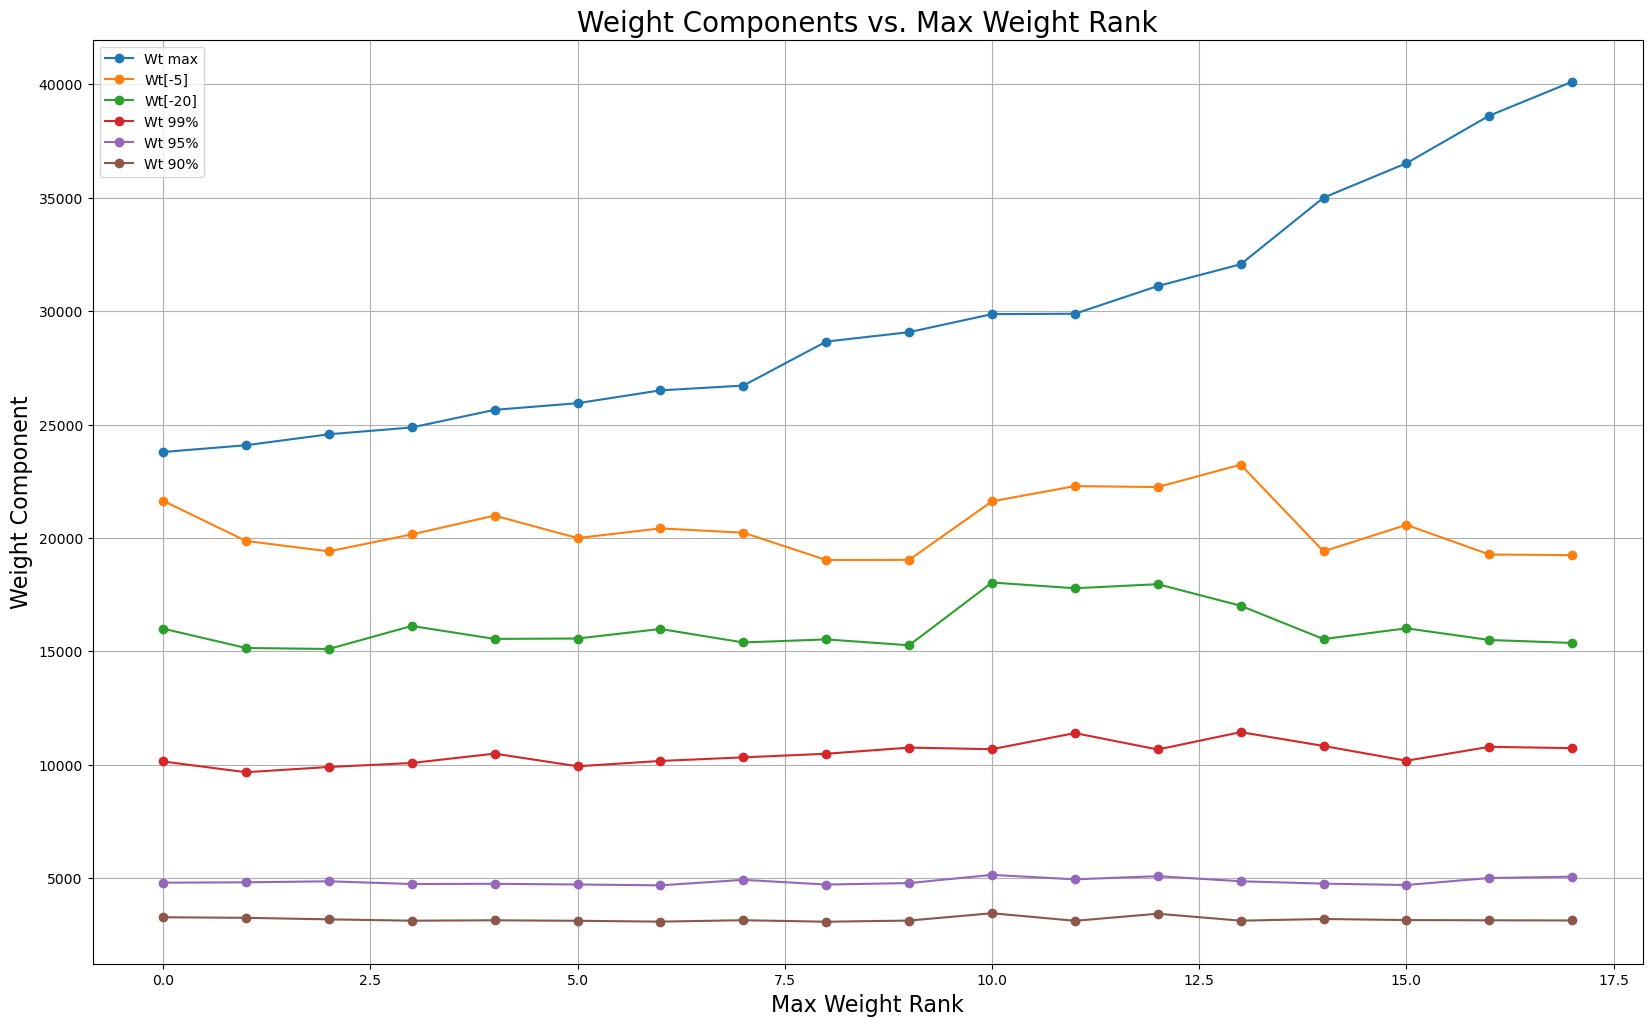

In [31]:
wts_max = []
wts_m1 = []
wts_m2 = []
wts_99  = []
wts_95  = []
wts_90  = []

#for i,score in enumerate(sorted_scores):
for index, row in result_df.iterrows():
    
    #model_index, fnorm_m, weights_m, smallest_cell = ranked[score]
    #model = MODELS[model_index]
    
    model_index = row['Model Index']
    weights_m = weight_map[model_index]
    sorted_weights = sorted(weights_m)
  
    wts_max.append(sorted_weights[-1])
    wts_m1.append(sorted_weights[-5])
    wts_m2.append(sorted_weights[-20])
    wts_99.append(np.percentile(weights_m, 99))
    wts_95.append(np.percentile(weights_m, 95))
    wts_90.append(np.percentile(weights_m, 90))
    
plt.figure(figsize=(20,12))
plt.plot(wts_max, label='Wt max', marker='o')
plt.plot(wts_m1, label='Wt[-5]', marker='o')
plt.plot(wts_m2, label='Wt[-20]', marker='o')
plt.plot(wts_99, label='Wt 99%', marker='o')
plt.plot(wts_95, label='Wt 95%', marker='o')
plt.plot(wts_90, label='Wt 90%', marker='o')
#plt.ylim(0, 100000)
plt.xlabel('Max Weight Rank', fontsize=16)
plt.ylabel('Weight Component', fontsize=16)
plt.title('Weight Components vs. Max Weight Rank', fontsize=20)
plt.grid()
plt.legend(loc='upper left')
plt.show()

#### Standard deviation of selected parts of the weight distribution

In [32]:
# # N largest weights
# lim_data = [
#     #(4, [], 'Top 4'),
#     (8, [], 'Top 8'),
#     (16, [], 'Top 16'),
#     (32, [], 'Top 32'),
#     (64, [], 'Top 64'),
#     (128, [], 'Top 128'),
#     (256, [], 'Top 256'),
# ]

# # uppermost percentiles
# pct_data = [
#     (99, [], '99%+'),
#     (97, [], '97%+'),
#     (95, [], '95%+'),
#     (93, [], '93%+'),
#     (90, [], '90%+'),
# ]

# for i, score in enumerate(sorted_scores):
#     model_index, fnorm_m, weights_m, smallest_cell = ranked[score]
#     sorted_weights = sorted(weights_m)
    
#     for lim, arr, label in lim_data:
        
#         if lim > len(sorted_weights):
#             break        
        
#         # the nth-from-the-max weight
#         wn = sorted_weights[-lim]

#         # extract all weights >= this value
#         samples = []
#         for w in weights_m:
#             if w >= wn:
#                 samples.append(w)    
    
#         std = np.std(samples)
#         arr.append(std)
            
# for i, score in enumerate(sorted_scores):
#     model_index, fnorm_m, weights_m, smallest_cell = ranked[score]
#     for lim, arr, label in pct_data:
#         wpct = np.percentile(weights_m, lim)
#         samples = []
#         for w in weights_m:
#             if w >= wpct:
#                 samples.append(w)
#         std = np.std(samples)
#         arr.append(std)

In [33]:
# # std. deviation of N largest weights vs. model index, linear scale
# plt.figure(figsize=(20,12))
# for lim, arr, label in lim_data:
#     if lim > len(sorted_weights):
#         continue
#     plt.plot(arr, label=label, marker='o')
# plt.xlabel('Raking Model Score Index', fontsize=16)
# plt.ylabel('Std. Deviation', fontsize=16)
# plt.title('Std. Deviation of N Largest Weights ({})'.format(STATE), fontsize=20)
# #plt.ylim(1.0e3, 1.0e5)
# #plt.yscale('log')
# plt.grid()
# plt.legend(loc='upper left')
# plt.show()

In [34]:
# # std. deviation of upper percentile weights vs. model index, linear scale
# plt.figure(figsize=(20,12))
# for lim, arr, label in pct_data:
#     plt.plot(arr, label=label, marker='o')
# plt.xlabel('Raking Model Score Index', fontsize=16)
# plt.ylabel('Std. Deviation', fontsize=16)
# plt.title('Std. Deviation of Upper Percentile Weights ({})'.format(STATE), fontsize=20)
# plt.grid()
# #plt.ylim(1.0e3, 1.0e5)
# #plt.yscale('log')
# plt.legend(loc='upper left')
# plt.show()

In [35]:
# # std. deviation of N largest weights vs. raking model score, log-log
# plt.figure(figsize=(20,12))
# for lim, arr, label in lim_data:
#     if lim > len(sorted_weights):
#         continue
#     plt.plot(sorted_scores, arr, label=label, marker='o')
# plt.xlabel('Raking Model Score', fontsize=16)
# plt.ylabel('Std. Deviation', fontsize=16)
# plt.title('Std. Deviation of N Largest Weights ({})'.format(STATE), fontsize=20)
# plt.grid()
# #plt.ylim(1.0e3, 1.0e5)
# #plt.xscale('log')
# #plt.yscale('log')
# plt.legend(loc='upper left')
# plt.show()

In [36]:
# # std. deviation of upper percentile weights vs. raking model score, log-log
# plt.figure(figsize=(20,12))
# for lim, arr, label in pct_data:
#     plt.plot(sorted_scores, arr, label=label, marker='o')
# plt.xlabel('Raking Model Score', fontsize=16)
# plt.ylabel('Std. Deviation', fontsize=16)
# plt.title('Std. Deviation of Upper Percentile Weights ({})'.format(STATE), fontsize=20)
# plt.grid()
# #plt.xscale('log')
# #plt.yscale('log')
# #plt.ylim(1.0e3, 1.0e5)
# plt.legend(loc='upper left')
# plt.show()

#### Compute percentage of population in upper weight components

In [37]:
# N largest weights
lim_data = [
    #(4, [], 'Top 4'),
    (8, [], 'Top 8'),
    (16, [], 'Top 16'),
    (32, [], 'Top 32'),
#     (64, [], 'Top 64'),
#     (128, [], 'Top 128'),
#     (256, [], 'Top 256'),
]

# uppermost percentiles
pct_data = [
    (99, [], '99%+'),
    (97, [], '97%+'),
    (95, [], '95%+'),
#     (93, [], '93%+'),x
#     (90, [], '90%+'),
]

# pct of population >= cutoff weight
max_data = [
    (90, [], '90%'),
    (85, [], '85%'),
    (80, [], '80%'),
    (75, [], '75%'),
    #(70, [], '70%'),
    #(60, [], '60%'),
]

for index, row in result_df.iterrows():
    model_index = row['Model Index']
    weights_m = weight_map[model_index]
    sorted_weights = sorted(weights_m)

# for i, score in enumerate(sorted_scores):
#     model_index, fnorm_m, weights_m, smallest_cell = ranked[score]
#     sorted_weights = sorted(weights_m)
    
    for lim, arr, label in lim_data:
        
        if lim > len(sorted_weights):
            break
        
        # the nth-from-the-max weight
        wn = sorted_weights[-lim]

        # extract all weights >= this value
        samples = []
        for w in weights_m:
            assert w >= 0
            if w >= wn:
                samples.append(w)    
             
        # the weighted population in the top N weights
        pop = np.sum(samples) #sorted_weights[-lim:])
        # pct of the target population this represents
        pct = 100.0 * (pop / TARGET_POPULATION)
        arr.append(pct)
                
# for i, score in enumerate(sorted_scores):
#     model_index, fnorm_m, weights_m, smallest_cell = ranked[score]
    
for index, row in result_df.iterrows():
    model_index = row['Model Index']
    weights_m = weight_map[model_index]
    sorted_weights = sorted(weights_m)    
    
    for lim, arr, label in pct_data:
        wpct = np.percentile(weights_m, lim)
        samples = []
        for w in weights_m:
            assert w >= 0
            if w >= wpct:
                samples.append(w)

        pop = np.sum(samples)
        pct = 100.0 * (pop / TARGET_POPULATION)
        arr.append(pct)
        
# for i, score in enumerate(sorted_scores):
#     model_index, fnorm_m, weights_m, smallest_cell = ranked[score]
    
for index, row in result_df.iterrows():
    model_index = row['Model Index']
    weights_m = weight_map[model_index]
    sorted_weights = sorted(weights_m)    
    
    for pct, arr, label in max_data:
        wmax = np.max(weights_m)
        cutoff = pct * 0.01 * wmax
        # extract all weights >= cutoff
        samples = []
        for w in weights_m:
            if w >= cutoff:
                samples.append(w)
        
        # fraction of the population in these weights
        pop_fraction = np.sum(samples) / TARGET_POPULATION
        arr.append(pop_fraction * 100.0)

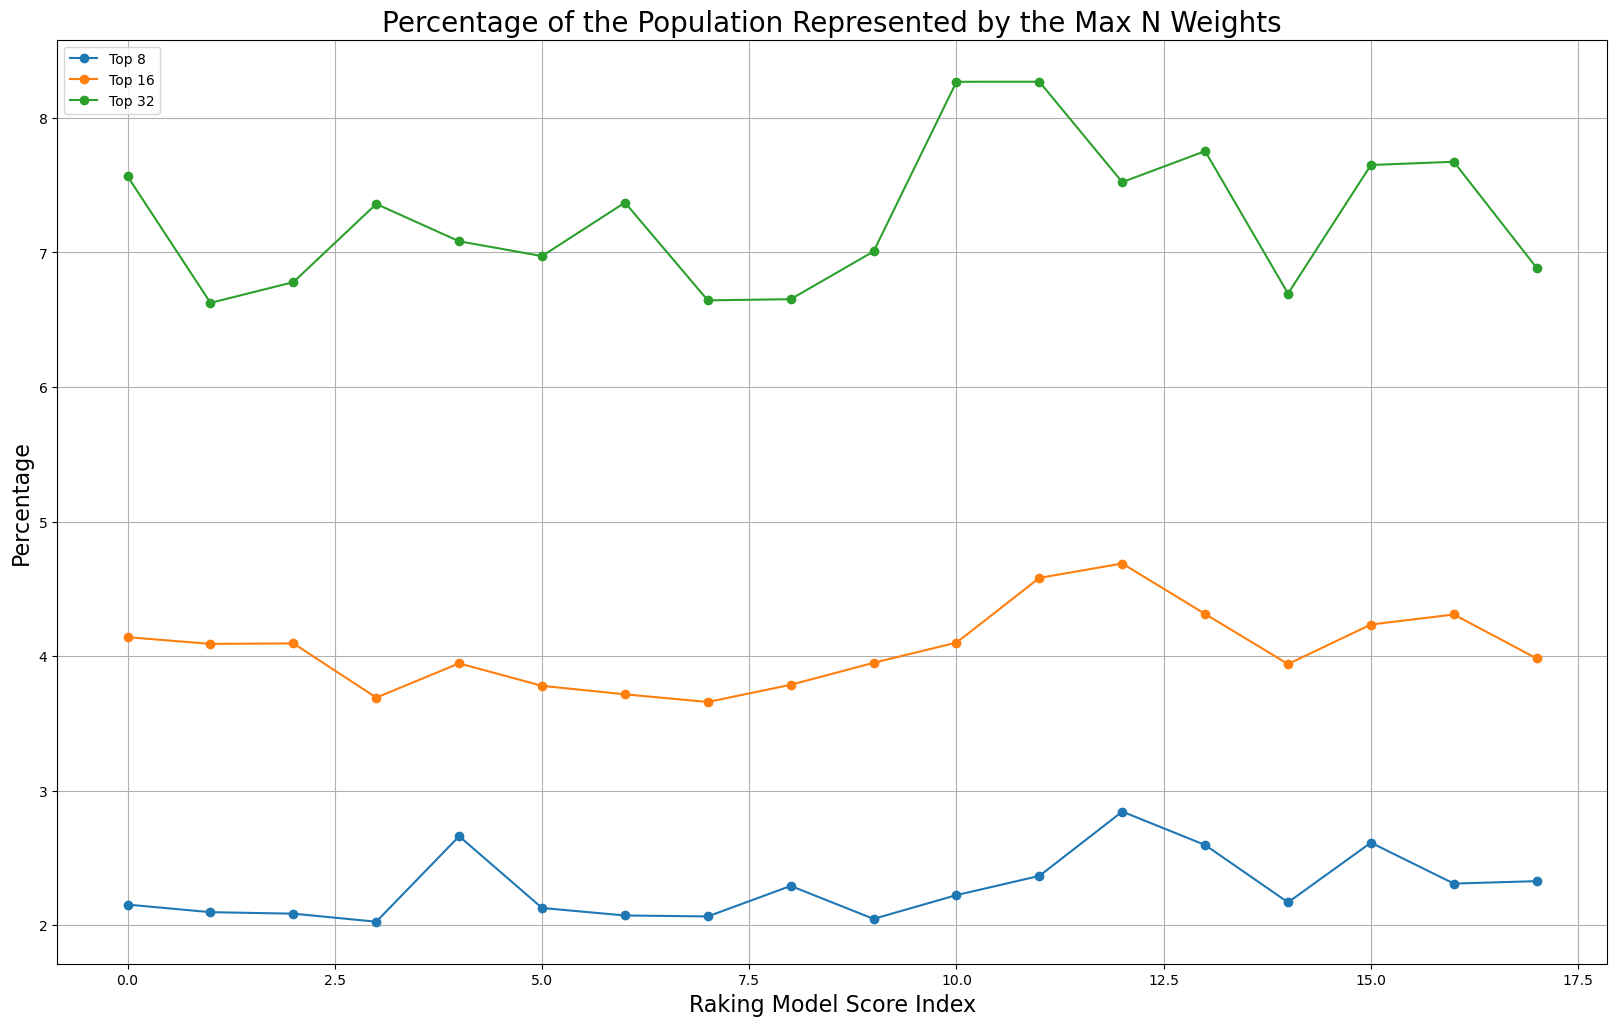

In [38]:
plt.figure(figsize=(20,12))
for lim, arr, label in lim_data:
    if lim > len(sorted_weights):
        continue
    plt.plot(arr, label=label, marker='o')
plt.xlabel('Raking Model Score Index', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title('Percentage of the Population Represented by the Max N Weights', fontsize=20)
plt.grid()
plt.legend(loc='upper left')
plt.show()

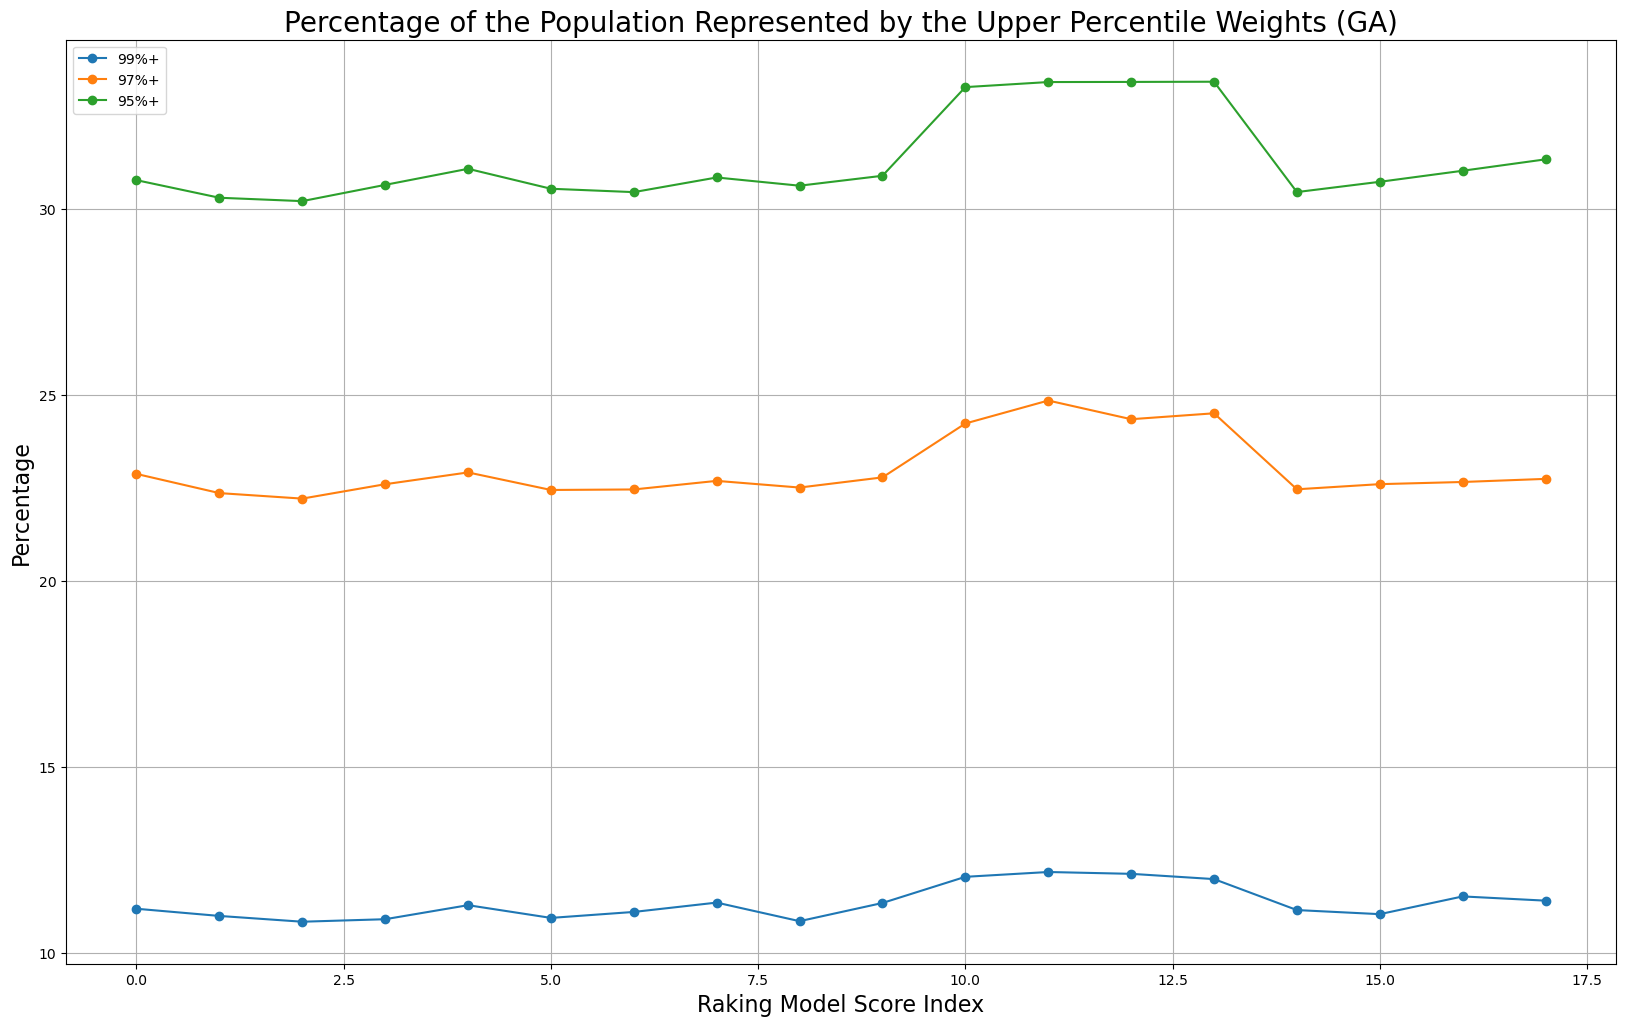

In [39]:
plt.figure(figsize=(20,12))
for lim, arr, label in pct_data:
    plt.plot(arr, label=label, marker='o')
plt.xlabel('Raking Model Score Index', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title('Percentage of the Population Represented by the Upper Percentile Weights ({})'.format(STATE), fontsize=20)
plt.grid()
plt.legend(loc='upper left')
plt.show()

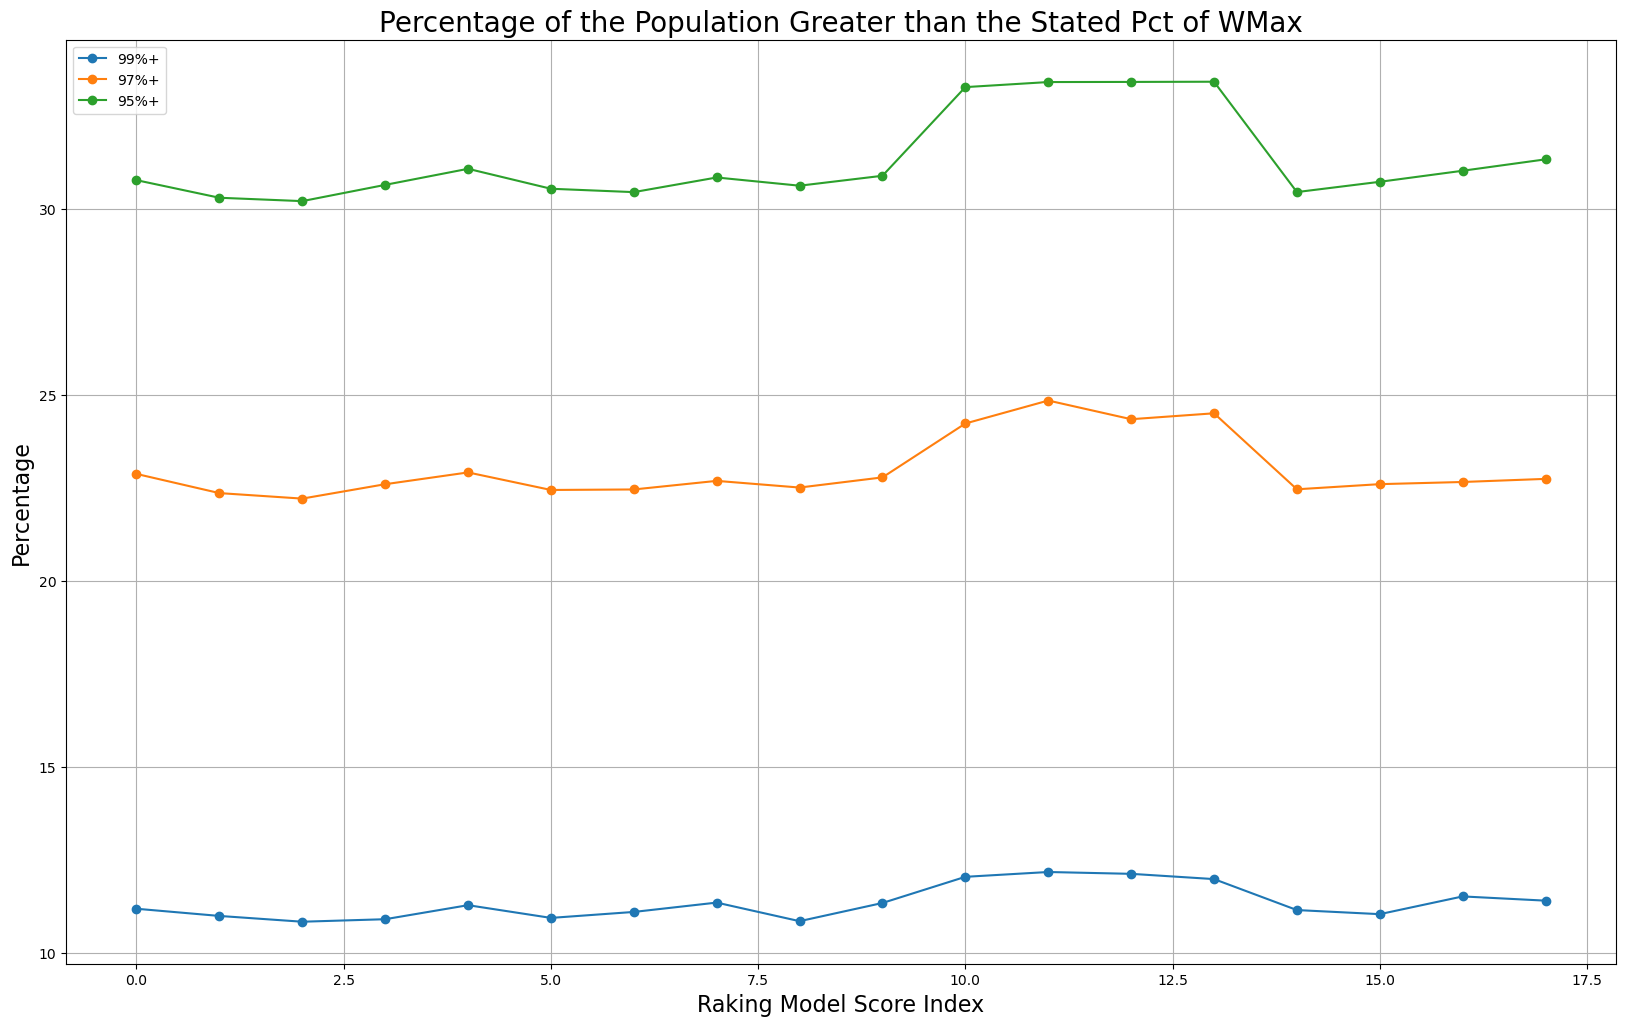

In [40]:
plt.figure(figsize=(20,12))
for lim, arr, label in pct_data:
    if lim > len(sorted_weights):
        continue
    plt.plot(arr, label=label, marker='o')
plt.xlabel('Raking Model Score Index', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title('Percentage of the Population Greater than the Stated Pct of WMax', fontsize=20)
plt.grid()
plt.legend(loc='upper left')
plt.show()

## Compute PDFs for All Variables and Compare with Target

Run the best model again, compute PDFs for all variables, and check for zero diffs with the target.

In [41]:
best_row = result_df.iloc[[0]]
best_row['Model Index'][0]

27

In [42]:
# best_score = sorted_scores[0]
# model_index, fnorm_m, weights_m, smallest_cell = ranked[best_score]
# model = MODELS[model_index]

# let the model with the minimum wmax be the "best" result
best_result = result_df.iloc[[0]]
model_index = best_result['Model Index'][0]
model = MODELS[model_index]

raking_result_tuple = raking.rake(model,
                                  SOURCE_SAMPLES,
                                  TARGET_SAMPLES,
                                  TARGET_WEIGHTS,
                                  BIN_COUNTS,
                                  TARGET_POPULATION)

if raking_result_tuple is None:
    print('\n*** No acceptable raking model was found. ***')
else:
    weights, unraked, target, raked, fnorm, smallest_cell = raking_result_tuple
    # compute PDFs
    target_pdfs = {}
    source_raked_pdfs = {}
    source_unraked_pdfs = {}

    # target pdfs
    for q in range(len(RAKEVARS)):
        target_pdfs[q] = pdf.to_pdf(BIN_COUNTS[q], TARGET_SAMPLES[q], weights=TARGET_WEIGHTS)

    # unraked source pdfs
    for q in range(len(RAKEVARS)):
        source_unraked_pdfs[q] = pdf.to_pdf(BIN_COUNTS[q], SOURCE_SAMPLES[q], weights=None)

    # raked source pdfs
    for q in range(len(RAKEVARS)):
        source_raked_pdfs[q] = pdf.to_pdf(BIN_COUNTS[q], SOURCE_SAMPLES[q], weights=weights)

    print('\nPDF diffs after raking for model {0}:\n'.format(model))   

    # diff between raked and target pdfs
    diffs = []
    for q in range(len(RAKEVARS)):
        diff = source_raked_pdfs[q] - target_pdfs[q]
        diffs.append(diff)
        print('{0:>{2}} : {1}'.format(RAKEVAR_NAMES[q], 
                                      np.array_str(diff, precision=5, suppress_small=True),
                                      maxlen))

    # check the diff vectors for the presence of any diff > 0.01 (i.e. 1%)
    all_ok = True
    THRESHOLD = 0.01
    for diff_vector in diffs:
        if np.any(diff_vector > THRESHOLD):
            all_ok = False
    
    # sum of the weights
    sum_of_weights = np.sum(weights)
    print()
    print('        Max weight : {0:.3f}'.format(np.max(weights)))
    print('Sum of the weights : {0:.3f}'.format(sum_of_weights))
    print('  Population total : {0:.3f}'.format(TARGET_POPULATION))
    print('        Difference : {0:.3f}'.format(abs(TARGET_POPULATION - sum_of_weights)))
    print('\nRaked PDFs differ from target PDFs by less than {0}%: {1}'.format(int(THRESHOLD * 100),
                                                                               all_ok))

/Users/rb230/miniconda3/envs/dev/lib/python3.10/site-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/Users/rb230/repos/gtri/cdc_projects/t10-raking/src/raking.py:356: RuntimeWarning: invalid value encountered in divide
  cell_weights = np.divide(raked, unraked)


ipfn converged: convergence_rate below threshold

PDF diffs after raking for model [[1], [3], [0, 2], [4, 5]]:

      Age : [ 0.  0. -0.  0. -0.  0.]
  RaceEth : [-0.  0. -0.  0. -0.]
Insurance : [-0.  0.]
Education : [ 0. -0. -0.  0.]
   Income : [-0.  0. -0.  0.  0.]
      Sex : [ 0. -0.]

        Max weight : 23788.793
Sum of the weights : 8115411.000
  Population total : 8115411.000
        Difference : 0.000

Raked PDFs differ from target PDFs by less than 1%: True


## Plot 1D Distributions Before and After Raking

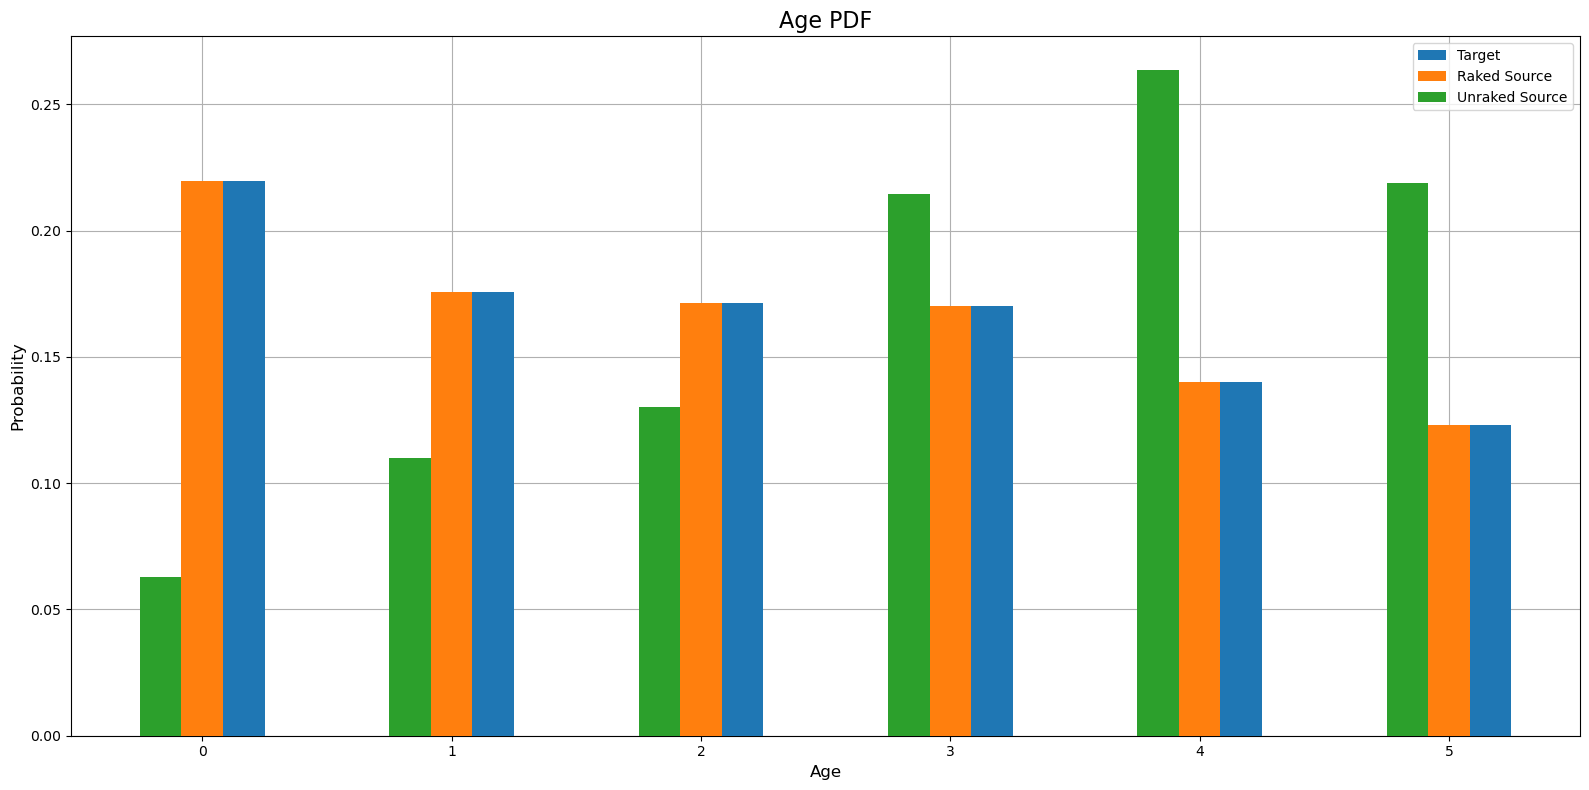

Unraked source PDF : [0.06287 0.10993 0.13029 0.2145  0.26368 0.21873]
  Raked source PDF : [0.21941 0.17576 0.1715  0.17013 0.14007 0.12312]
        Target PDF : [0.21941 0.17576 0.1715  0.17013 0.14007 0.12312]


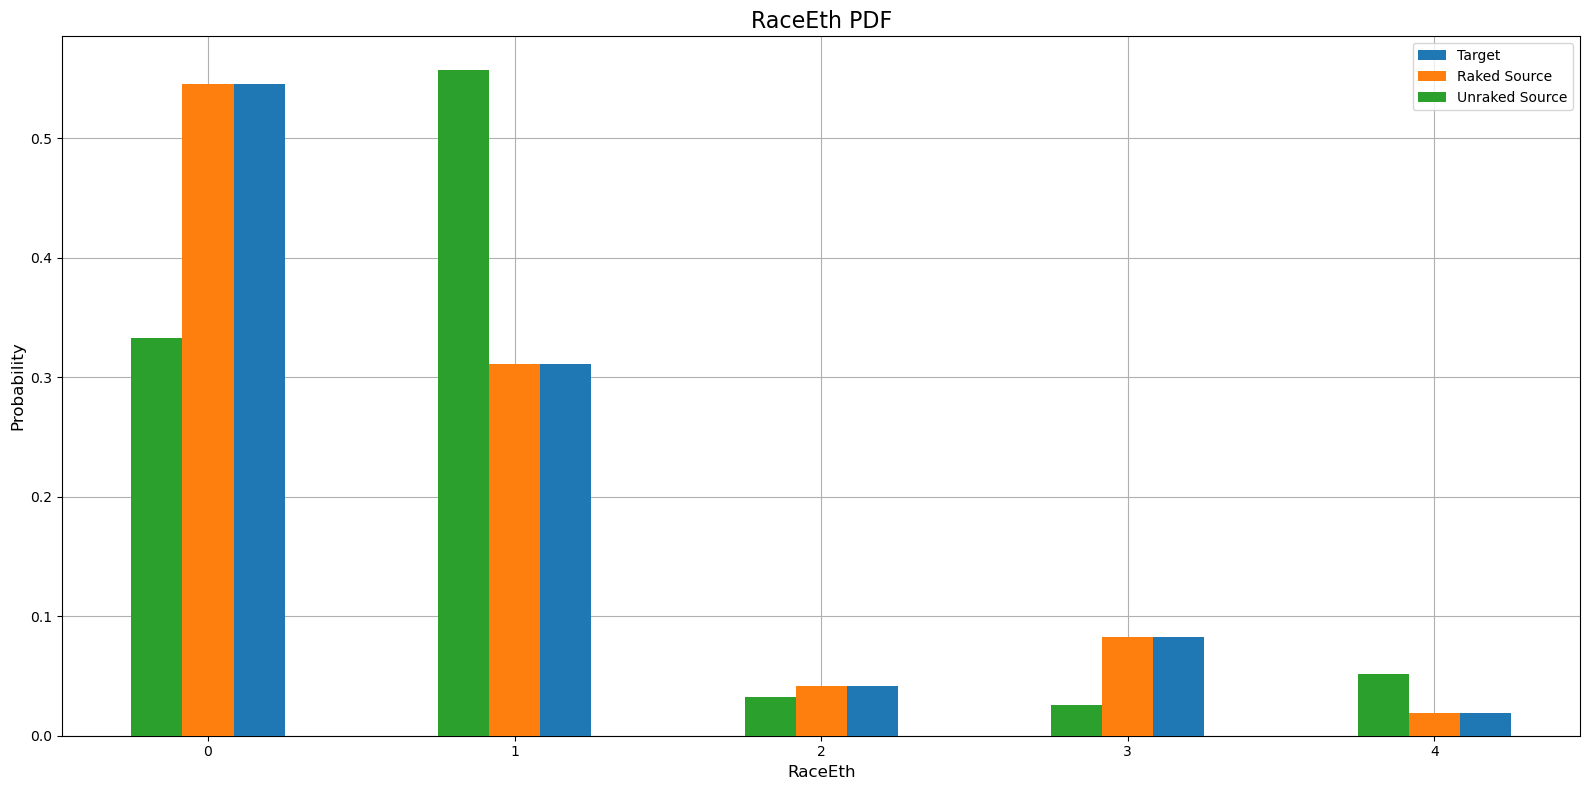

Unraked source PDF : [0.3329  0.55749 0.03257 0.02541 0.05163]
  Raked source PDF : [0.54542 0.31103 0.04199 0.08264 0.01891]
        Target PDF : [0.54542 0.31103 0.04199 0.08264 0.01891]


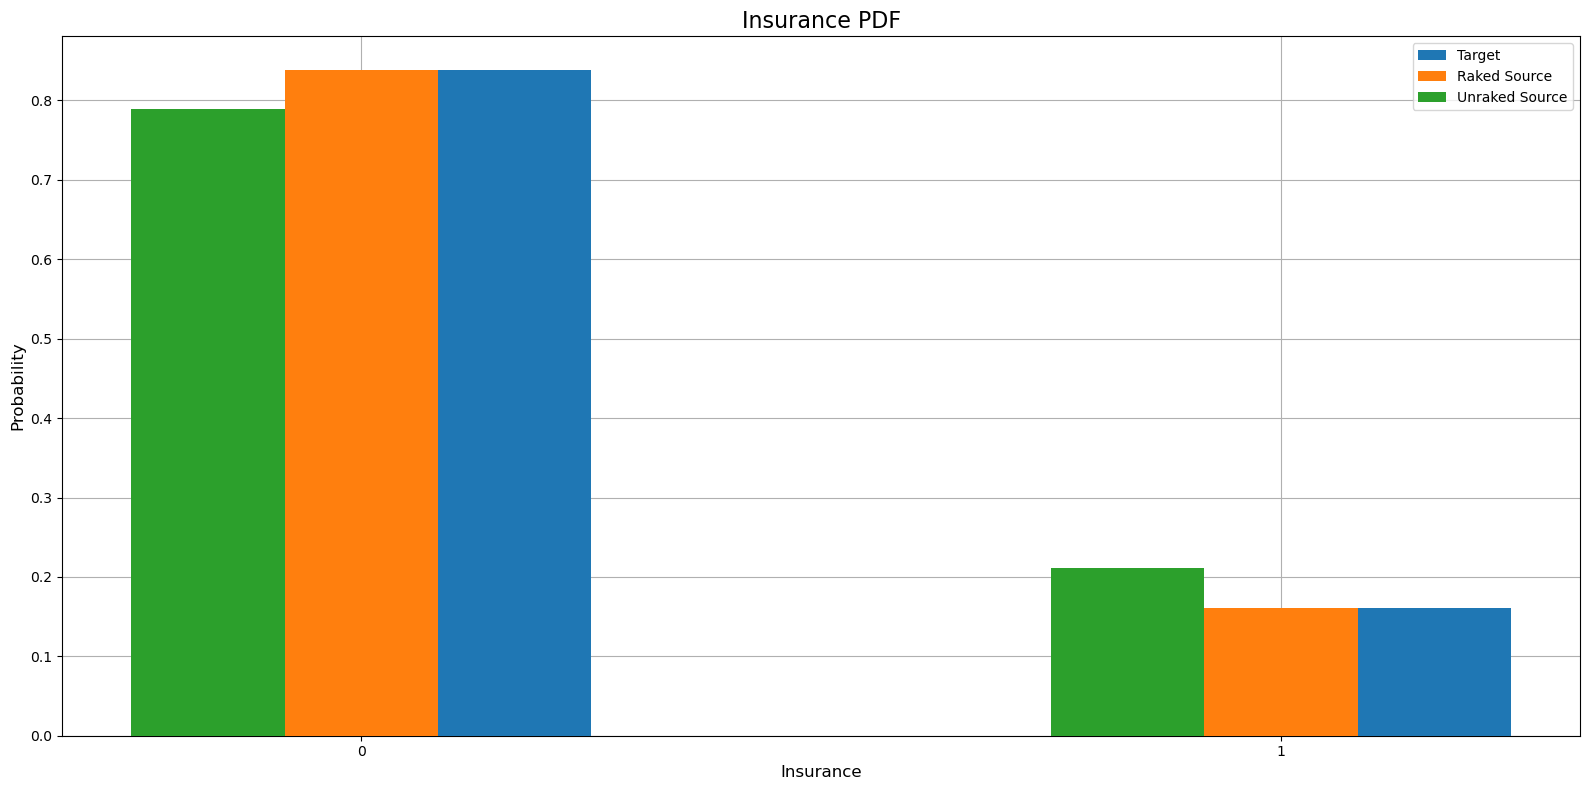

Unraked source PDF : [0.78876 0.21124]
  Raked source PDF : [0.83884 0.16116]
        Target PDF : [0.83884 0.16116]


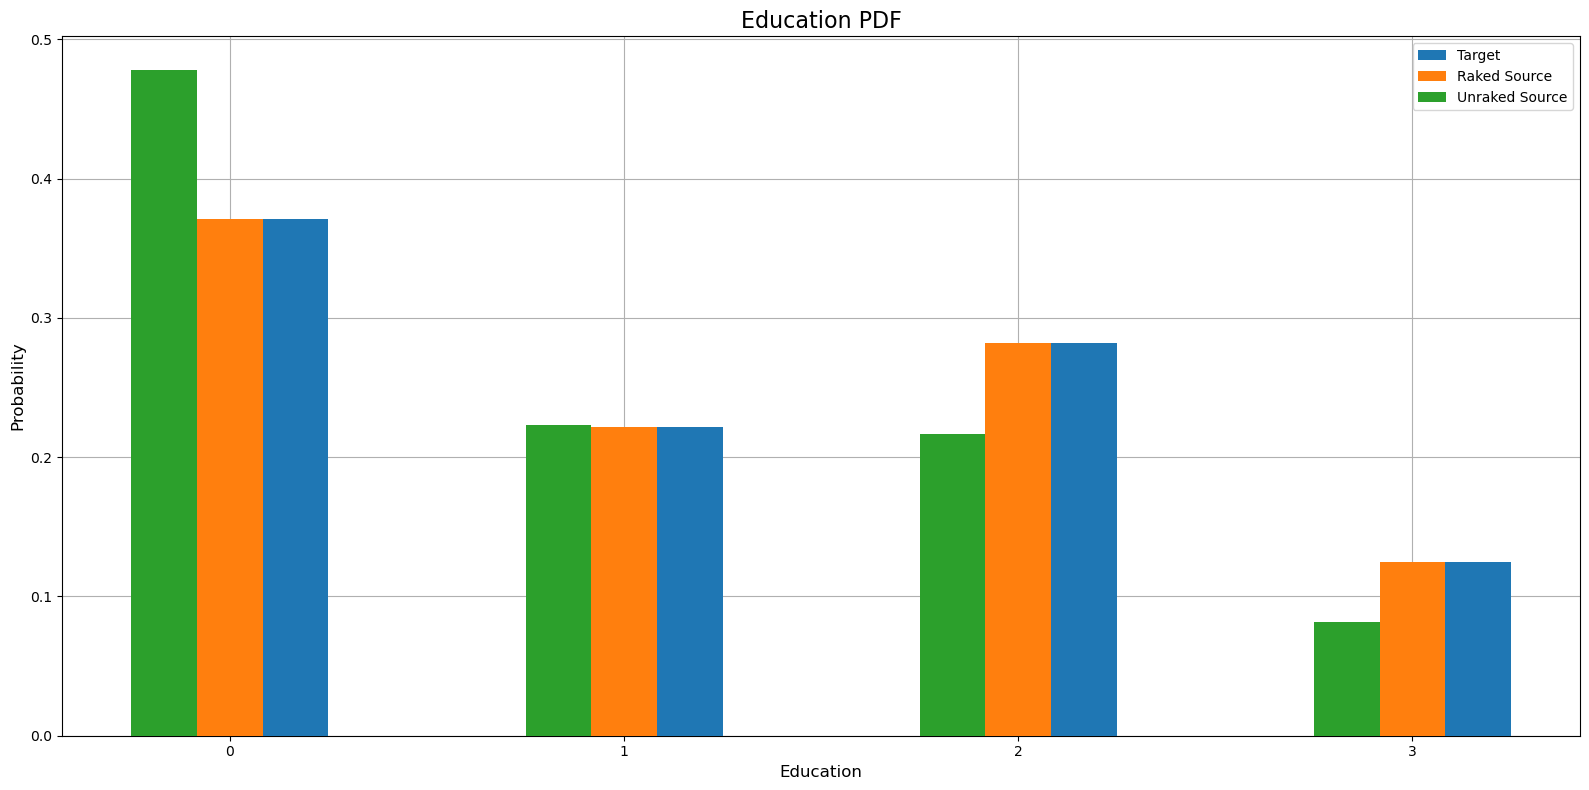

Unraked source PDF : [0.47834 0.22329 0.21678 0.0816 ]
  Raked source PDF : [0.3714  0.22176 0.28216 0.12468]
        Target PDF : [0.3714  0.22176 0.28216 0.12468]


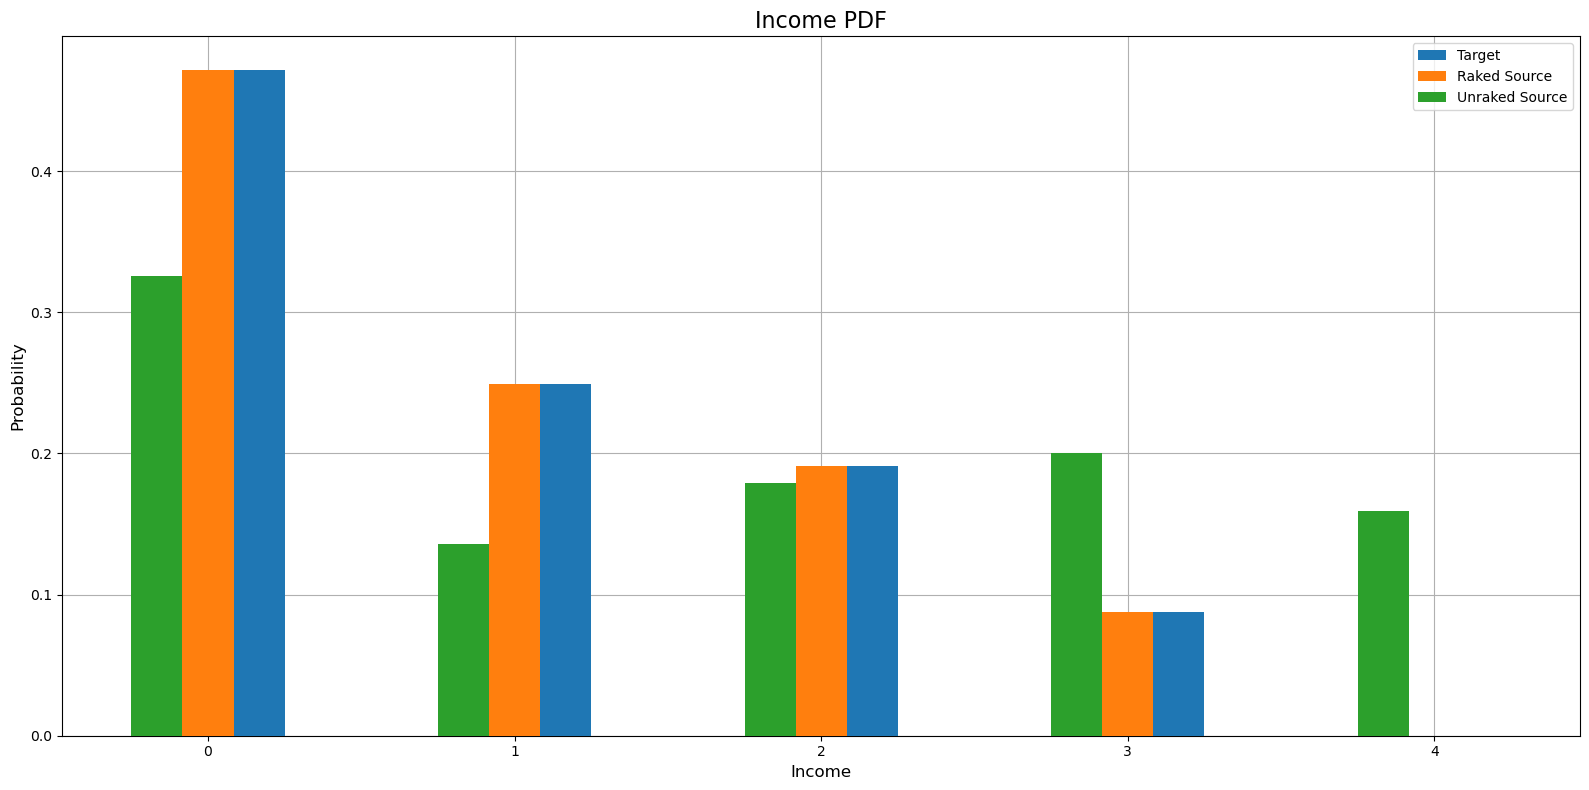

Unraked source PDF : [0.32573 0.13583 0.17932 0.20016 0.15896]
  Raked source PDF : [0.47194 0.24911 0.19114 0.08781 0.     ]
        Target PDF : [0.47194 0.24911 0.19114 0.08781 0.     ]


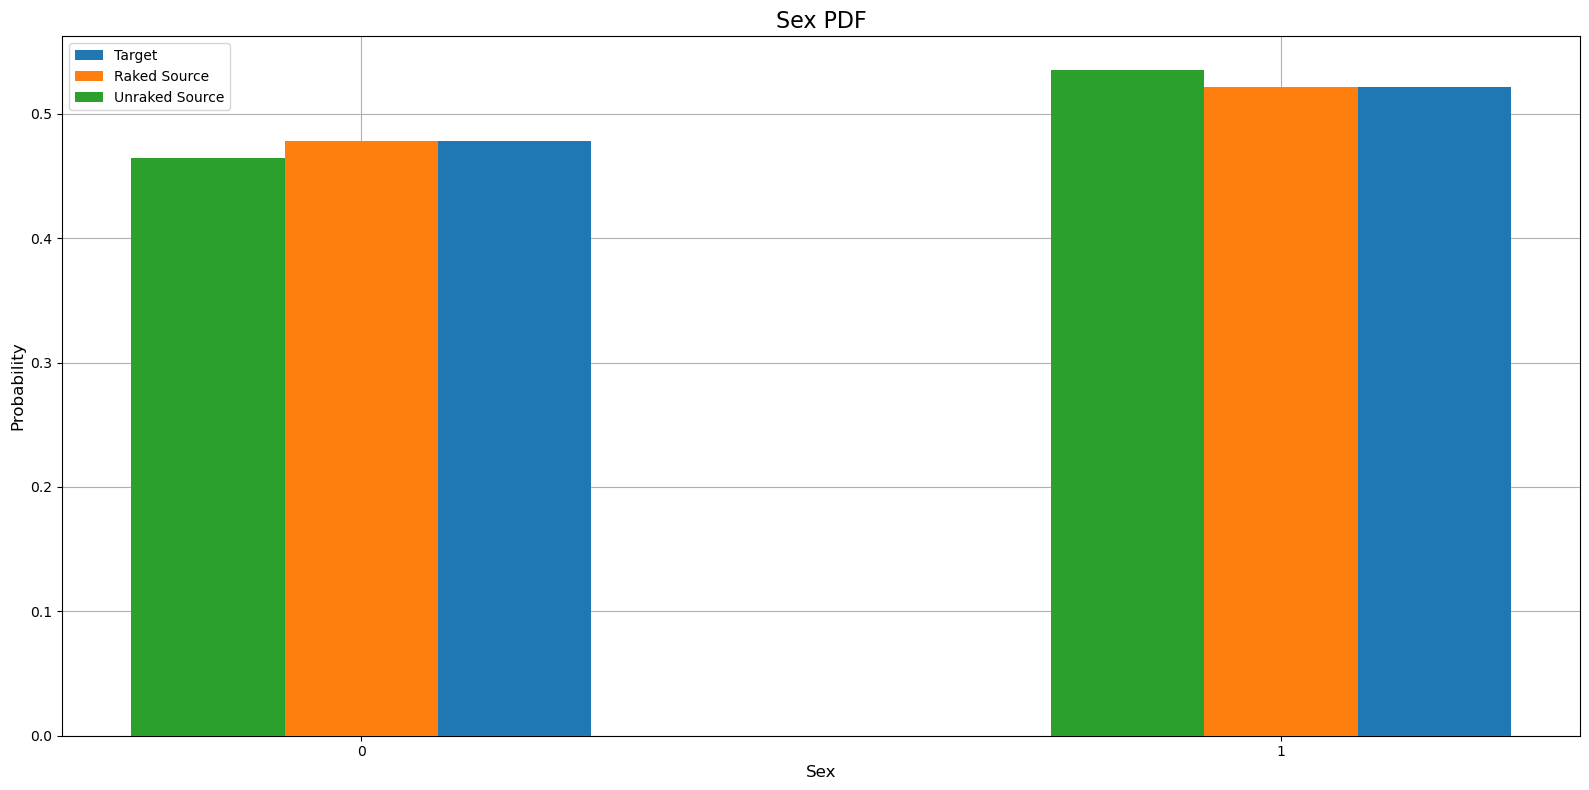

Unraked source PDF : [0.4645 0.5355]
  Raked source PDF : [0.47813 0.52187]
        Target PDF : [0.47813 0.52187]


In [43]:
plot_pdfs(source_unraked_pdfs, source_raked_pdfs, target_pdfs)

#### Write weighted source samples to disk

In [44]:
# insert a column for the weights into the source dataframe
final_df = source_df.assign(Weight = weights)
final_df

,AGE_GROUPING,RACE_GROUPING,INSURANCE_GROUPING,EDUCATION_GROUPING,INCOME_GROUPING,SEX_AT_BIRTH,STATE,Weight
0,1,0,0,1,0,1,GA,6104.188759
1,4,1,0,2,0,1,GA,986.240832
2,4,0,0,2,3,1,GA,397.400948
3,2,4,0,0,4,1,GA,0.000000
4,1,1,0,0,0,1,GA,1552.044401
...,...,...,...,...,...,...,...,...
6135,3,0,0,0,3,0,GA,848.979474
6136,5,1,1,0,4,0,GA,0.000000
6137,2,0,0,0,2,1,GA,2025.249399
6138,5,1,0,0,0,1,GA,698.117293


In [45]:
# construct output file name from the source file name
output_file = os.path.join(DATA_DIR, OUTPUT_FILE_NAME)

# write output file
final_df.to_csv(output_file, index=False)
print('Wrote file "{0}".'.format(output_file))

Wrote file "data/aou_weighted.csv".


#### Check all zero-weight tuples

Zero weights will be assigned to any source individual with a combination of characteristics **not** appearing in the target population.

Explicitly check that none of these individuals appear in the PUMS data.

In [46]:
zero_df = final_df.loc[final_df['Weight'] == 0]
zero_df

,AGE_GROUPING,RACE_GROUPING,INSURANCE_GROUPING,EDUCATION_GROUPING,INCOME_GROUPING,SEX_AT_BIRTH,STATE,Weight
3,2,4,0,0,4,1,GA,0.0
13,1,1,1,1,4,0,GA,0.0
16,2,1,0,3,4,1,GA,0.0
18,3,0,0,0,4,0,GA,0.0
24,4,1,0,3,4,0,GA,0.0
...,...,...,...,...,...,...,...,...
6107,4,2,0,0,4,1,GA,0.0
6118,0,1,1,0,4,0,GA,0.0
6119,5,1,0,0,4,1,GA,0.0
6120,2,1,1,0,4,0,GA,0.0


In [47]:
print('Found {0} zero-weight source tuples.'.format(len(zero_df)))

Found 976 zero-weight source tuples.


In [48]:
# drop the weight col, not needed for these checks
zero_df = zero_df.drop(columns=['Weight'])

# convert df to set of tuples
zero_wt_tup_set = set(zero_df.itertuples(index=False, name=None))

# drop the weight col from the pums df
pums_no_wt_df = pums_df.drop(columns=[PUMS_WEIGHT_COL])
target_tup_set = set(pums_no_wt_df.itertuples(index=False, name=None))

# these sets should be disjoint, meaning that none of the zero wt tuples occur in the PUMS population
error_population = len(zero_wt_tup_set.intersection(target_tup_set))
    
# this number should be zero
print('Number of zero-weight source samples found in the target population: {0}.'.format(error_population))

Number of zero-weight source samples found in the target population: 0.


#### Find the individuals with the maximum weight

In [49]:
weight_samples = final_df['Weight'].values
nonzero_weights = weight_samples[weight_samples > 0]
min_wt = np.min(nonzero_weights)
max_wt = np.max(nonzero_weights)
print('Min nonzero weight: {0:.3f}'.format(min_wt))
print('Max nonzero weight: {0:.3f}'.format(max_wt))

sorted_weights = sorted(nonzero_weights, reverse=True)
max_wt_df = final_df[final_df['Weight'].isin(sorted_weights[:10])]
max_wt_df

Min nonzero weight: 1.217
Max nonzero weight: 23788.793


,AGE_GROUPING,RACE_GROUPING,INSURANCE_GROUPING,EDUCATION_GROUPING,INCOME_GROUPING,SEX_AT_BIRTH,STATE,Weight
1402,0,3,1,0,1,1,GA,23499.003407
2595,0,0,0,2,1,1,GA,19371.837145
2653,0,0,1,3,1,0,GA,21264.847039
3185,0,3,1,0,0,1,GA,21637.231273
3191,0,3,0,0,0,1,GA,22309.615314
3370,0,3,0,0,1,0,GA,23788.792746
3371,0,0,0,3,0,1,GA,20562.330576
4674,0,0,0,3,1,1,GA,22331.613049
4783,0,0,0,2,1,0,GA,19019.687328
5216,0,0,1,2,1,0,GA,18446.457622


#### Plot a histogram of the nonzero weights

In [50]:
def plot_weight_distribution(plot_weights, title):
    
    fig = plt.figure(figsize=(16,8))
    plt.hist(plot_weights, bins=100, edgecolor='k', alpha=0.5)
    plt.xlabel('$w_i$', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title(title, fontsize=18)
    plt.yscale('log')
    plt.grid()
    plt.show()

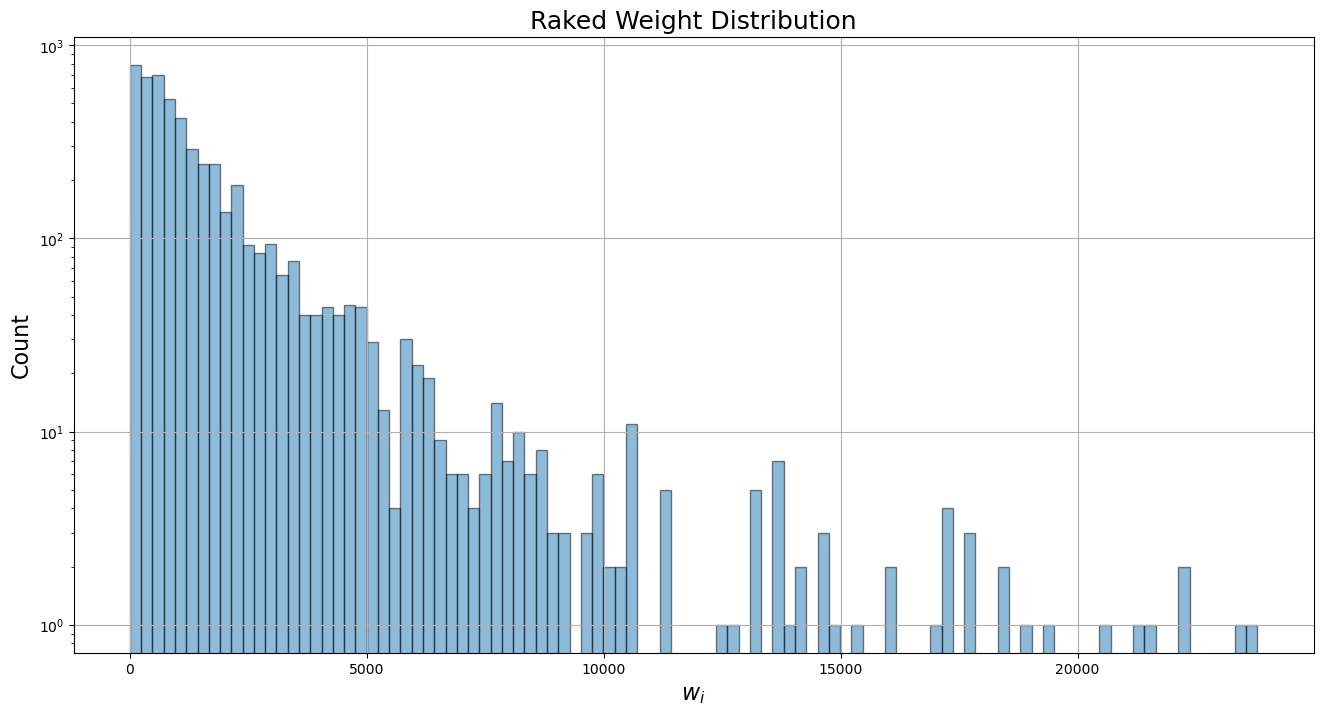

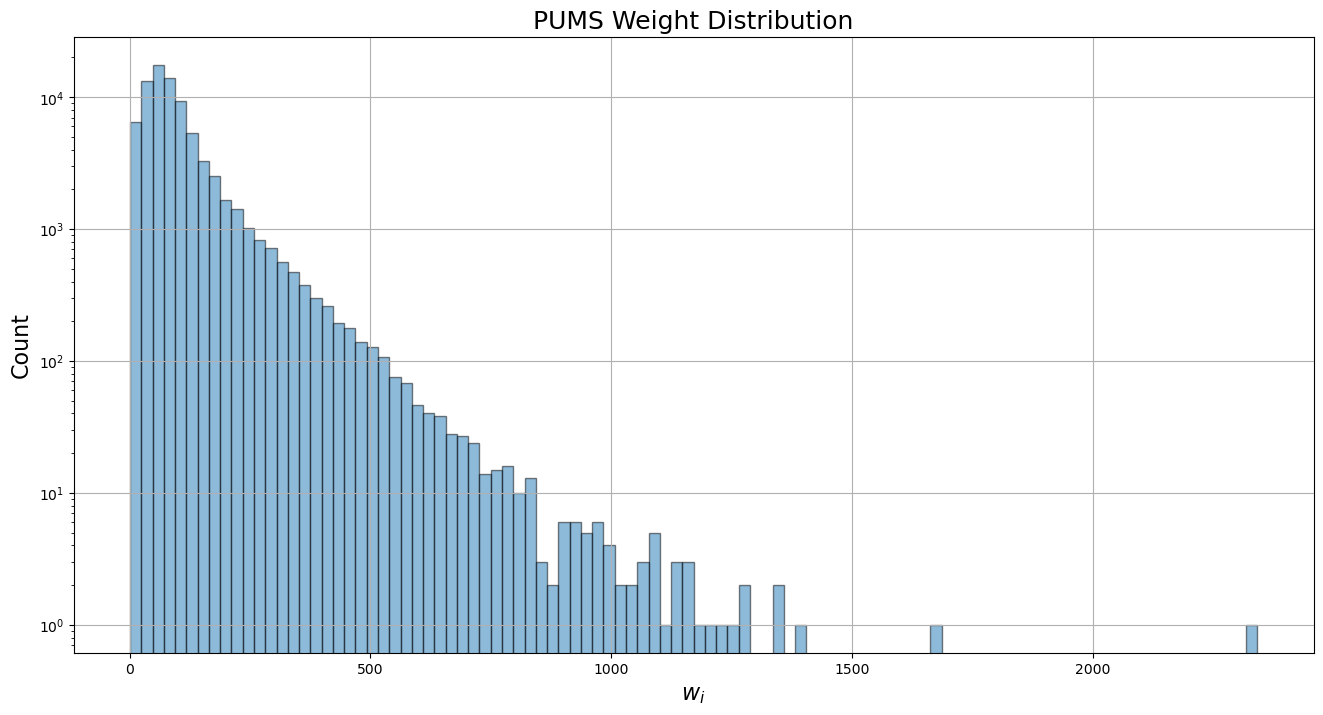

In [51]:
#nhis_weights = raw_source_df['Weight'].values
#plot_weight_distribution(nhis_weights, 'NHIS Weight Distribution')

raked_weights = nonzero_weights
plot_weight_distribution(raked_weights, 'Raked Weight Distribution')

target_weights = pums_df['PWGTP'].values
plot_weight_distribution(target_weights, 'PUMS Weight Distribution')

#### Find sets of common tuples

In [52]:
# drop the weight column from the PUMS dataframe, so that only the variable cols remain
target_no_wt_df = pums_df.drop(columns=['PWGTP'])

# get set of (unique) target tuples
target_tuples = set(target_no_wt_df.itertuples(index=False, name=None))

# get set of (unique) source tuples
source_tuples = set(source_df.itertuples(index=False, name=None))

# intersection
shared_tuples = source_tuples.intersection(target_tuples)

print(  'Unique PUMS tuples: {0}'.format(len(target_tuples)))
print('Unique source tuples: {0}'.format(len(source_tuples)))
print('       Shared tuples: {0}'.format(len(shared_tuples)))

Unique PUMS tuples: 1450
Unique source tuples: 1234
       Shared tuples: 0


### AllOfUs Top Five Models

In [53]:
best_results_imputed = [
    # AL
    '[02]', '[12]', '[35]', '[24]', '[]',    
    # AZ
    '[01]', '[01][24][35]', '[01][23][45]', '[04][15][23]', '[15]',
    # CA
    '[15]', '[01][23][45]', '[45]', '[01]', '[02]',
    # CT
    '[]', '[35]', '[45]',
    # FL
    '[35]', '[02]', '[24]', '[]', '[15]',
    # GA
    '[]', '[25]', '[15]', '[35]', '[23]',
    # IL
    '[01]', '[]', '[03][14][25]', '[25]', '[03]',
    # LA
    '[05]', '[15]', '[25]', '[23]', '[]',
    # MA
    '[01][23][45]', '[01]', '[45]', '[25]', '[]',
    # MI
    '[45]', '[35]', '[15]', '[23]', '[02]',
    # MS
    '[35]', '[23]', '[45]', '[]', '[25]',
    # NY
    '[03][15][24]', '[03]', '[15]', '[24]', '[02]',
    # PA
    '[45]', '[25]', '[24]', '[02]', '[]',
    # SC
    '[35]', '[02]', '[15]', '[25]', '[]',
    # TN
    '[25]', '[35]', '[]', '[23]', '[45]',
    # TX
    '[01][23][45]', '[45]', '[01]', '[14]', '[12]',
    # WI
    '[45]', '[23]', '[25]', '[]', '[35]',
    
    # fewer than 1K AllOfUs samples
    
#     # MN
#     '[45]', '[35]', '[04]', '[]', '[03]',
#     # WA
#     '[15]', '[]', '[23]', '[25]', '[45]',
#     # NC
#     '[02]', '[35]', '[02][14][35]', '[24]', '[]',
#     # NM
#     '[15]', '[35]', '[45]', '[03][15][24]', '[01][24][35]',
#     # NJ
#     '[01][24][35]', '[01]', '[01][23][45]', '[03][12][45]', '[12]',
#     # MO
#     '[45]', '[35]', '[]', '[03]', '[04]',
#     # NV
#     '[01][23][45]', '[15]', '[01]', '[04][15][23]', '[04]',
#     # AR
#     '[02]', '[01]', '[35]', '[02][14][35]', '[]',
#     # UT
#     '[03][15][24]', '[15]', '[03]', '[]', '[24]',
#     # CO
#     '[04][15][23]', '[15]', '[01]', '[04]', '[]',
#     # OR
#     '[15]', '[23]', '[]', '[45]', '[25]',
#     # KS
#     '[45]', '[35]', '[]', '[04]', '[03]',
#     # NE
#     '[45]', '[35]', '[03]', '[]', '[04]',
#     # MD
#     '[24]', '[35]', '[02]', '[]', '[25]',
#     # ND
#     '[45]', '[35]', '[]', '[04]', '[03]',
#     # OH
#     '[01]', '[35]', '[25]', '[]', '[23]',
#     # IN
#     '[01]', '[35]', '[23]', '[25]', '[]',
#     # ID
#     '[23]', '[25]', '[15]', '[]', '[24]',
#     # ME
#     '[35]', '[01]', '[23]', '[]', '[15]',
#     # OK
#     '[01]', '[15]', '[35]', '[03][14][25]', '[03]',
#     # MT
#     '[]', '[35]', '[24]', '[23]', '[15]',
#     # NH
#     '[35]', '[15]', '[01]', '[]', '[25]',
#     # VA
#     '[02]', '[35]', '[24]', '[]', '[25]',

]

ctr = Counter(best_results_imputed)
ctr_tuples = [(v,k) for k,v in ctr.items()]
for tup in sorted(ctr_tuples, key=lambda x: x[0], reverse=True):
    count = tup[0]
    k = tup[1]
    #print('{1:2d} => {0}'.format(k, count))
    print('{0:>12} : {1}'.format(k, count))

          [] : 12
        [35] : 9
        [45] : 9
        [25] : 9
        [15] : 8
        [02] : 7
        [23] : 6
        [01] : 5
        [24] : 4
[01][23][45] : 4
        [12] : 2
        [03] : 2
[01][24][35] : 1
[04][15][23] : 1
[03][14][25] : 1
        [05] : 1
[03][15][24] : 1
        [14] : 1


In [54]:
# count interactions
interactions = []
for s in best_results_imputed:
    iterator = re.finditer(r'\[(\d+)\]', s)
    for match in iterator:
        interactions.append(match.group())

ctr2 = Counter(interactions)
ctr2_tuples = [(v,k) for k,v in ctr2.items()]
for tup in sorted(ctr2_tuples, key=lambda x: x[0], reverse=True):
    count = tup[0]
    k = tup[1]
    #print('{1:2d} => {0}'.format(k, count))
    print('{0:>4} : {1}'.format(k, count))

[45] : 13
[23] : 11
[35] : 10
[01] : 10
[15] : 10
[25] : 10
[02] : 7
[24] : 6
[03] : 4
[12] : 2
[14] : 2
[04] : 1
[05] : 1


### Check marginal totals

In [60]:
final_df.columns

Index(['AGE_GROUPING', 'RACE_GROUPING', 'INSURANCE_GROUPING',
       'EDUCATION_GROUPING', 'INCOME_GROUPING', 'SEX_AT_BIRTH', 'STATE',
       'Weight'],
      dtype='object')

In [63]:
col_names = [col for col in final_df.columns[:-2]]
col_names

['AGE_GROUPING',
 'RACE_GROUPING',
 'INSURANCE_GROUPING',
 'EDUCATION_GROUPING',
 'INCOME_GROUPING',
 'SEX_AT_BIRTH']

In [71]:
sum_of_weights = np.sum(final_df['Weight'].values)
print('Sum of weights: {0}'.format(sum_of_weights))
var_names = [col for col in final_df.columns[:-2]]
source_counts = weighted_value_counts(final_df, final_df['Weight'].values, BIN_COUNTS, var_names)
for i, counts in enumerate(source_counts):
    print('{0}: '.format(var_names[i]))
    checksum = 0
    for k in range(len(counts)):
        count = counts[k]
        print('\t{0} : {1:>15}'.format(k, count))
        checksum += count
    assert np.isclose(sum_of_weights, checksum)
    print()

Sum of weights: 8115411.0
AGE_GROUPING: 
	0 : 1780596.0048535306
	1 : 1426402.0062999027
	2 : 1391775.9865547423
	3 : 1380709.002454446
	4 : 1136733.9948420557
	5 : 999194.0049953227

RACE_GROUPING: 
	0 : 4426337.80977318
	1 : 2524140.0454107025
	2 : 340795.9825961625
	3 : 670674.184924179
	4 : 153462.9772957618

INSURANCE_GROUPING: 
	0 : 6807529.991732492
	1 : 1307881.008267518

EDUCATION_GROUPING: 
	0 : 3014030.0061349245
	1 : 1799700.9920588546
	2 : 2289841.9892185256
	3 : 1011838.0125876847

INCOME_GROUPING: 
	0 : 3829965.999999997
	1 : 2021634.000000002
	2 : 1551200.999999996
	3 :        712610.0
	4 :             0.0

SEX_AT_BIRTH: 
	0 : 3880224.999999999
	1 : 4235185.999999983



In [72]:
sum_of_weights = np.sum(pums_df['PWGTP'].values)
print('Sum of weights: {0}'.format(sum_of_weights))
var_names = [col for col in pums_df.columns[:-1]]
target_counts = weighted_value_counts(pums_df, pums_df['PWGTP'].values, BIN_COUNTS, var_names)
for i, counts in enumerate(target_counts):
    print('{0}: '.format(var_names[i]))
    checksum = 0
    for k in range(len(counts)):
        count = counts[k]
        print('\t{0} : {1:>15}'.format(k, count))
        checksum += count
    assert np.isclose(sum_of_weights, checksum)
    print()

Sum of weights: 8115411
Age: 
	0 :       1780596.0
	1 :       1426402.0
	2 :       1391776.0
	3 :       1380709.0
	4 :       1136734.0
	5 :        999194.0

RaceEth: 
	0 :       4426338.0
	1 :       2524140.0
	2 :        340796.0
	3 :        670674.0
	4 :        153463.0

Insurance: 
	0 :       6807530.0
	1 :       1307881.0

Education: 
	0 :       3014030.0
	1 :       1799701.0
	2 :       2289842.0
	3 :       1011838.0

Income: 
	0 :       3829966.0
	1 :       2021634.0
	2 :       1551201.0
	3 :        712610.0
	4 :             0.0

Sex: 
	0 :       3880225.0
	1 :       4235186.0



In [78]:
for i in range(len(RAKEVAR_NAMES)):
    counts_t = target_counts[i]
    counts_s = source_counts[i]
    diff = counts_t - counts_s
    print('Var: {0:9}, max diff: {1:.3f}'.format(RAKEVAR_NAMES[i], np.max(diff)))

Var: Age      , max diff: 0.013
Var: RaceEth  , max diff: 0.190
Var: Insurance, max diff: 0.008
Var: Education, max diff: 0.011
Var: Income   , max diff: 0.000
Var: Sex      , max diff: 0.000
